In [1]:
%pip install pandas numpy seaborn torch matplotlib scipy openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import scipy

Здесь и дялее в качестве уровня доверия будем использовать значение 0.95

In [3]:
alpha = 0.05

In [4]:
df = pd.read_excel('Book2.xlsx')

In [5]:
df.shape

(60, 24)

In [6]:
df.head()

0.00   0.50    1.00    1.50    2.00   3.00   3.33   3.66   4.00   4.33   \
0      0  407.0  1000.0  1200.0  1360.0   1750   1540   1660   1540   1950   
1      0  121.0   225.0   708.0  1440.0   2510   1750   1760   1850   1770   
2      0  157.0   453.0   731.0   841.0    911    972    951    968    926   
3      0  297.0   508.0  1030.0  1140.0   1480   1480   1410   1360   1200   
4      0  136.0   195.0   640.0  1260.0   1530   1440   1500   1620   1600   

   ...  6.00   7.00   8.00   10.00  12.00  16.00  24.00  48.00  72.00  96.00  
0  ...   1080   1050   1060    872    945    893    579  181.0   51.6   13.8  
1  ...   1240   1250   1220   1320   1140   1030    741  323.0   89.8   32.9  
2  ...    717    673    654    514    524    477    260   75.5   21.9    0.0  
3  ...    893    847    900    825    677    525    472  245.0  101.0   44.2  
4  ...   1110    946    998   1060    860    881    756  526.0  271.0  147.0  

[5 rows x 24 columns]

In [7]:
x = np.array([float(elem) for elem in df.columns])
y = df.iloc[0,]
for interp in [scipy.interpolate.CubicSpline, scipy.interpolate.PchipInterpolator,
               scipy.interpolate.make_interp_spline, scipy.interpolate.interp1d]:
    func = interp(x, y)
    x_cont = np.linspace(0, np.max(x), 2000)
    # plt.title(f"{interp.__name__}")
    # plt.plot(x, y)
    # plt.plot(x_cont, func(x_cont))
    # plt.show()

In [8]:
interpolator = scipy.interpolate.PchipInterpolator

In [9]:
squares = []
integrator = scipy.integrate.quad_vec
for i in range(len(df)):
    x = [float(elem) for elem in df.select_dtypes(include=['float64', 'int64'])]
    y = df.iloc[i,]
    func = interpolator(x, y)
    x_cont = np.linspace(0, np.max(x), 2000)
    area, eps = integrator(func, 0, np.max(x))
    squares.append(area)
    # plt.plot(x, y)
    # plt.plot(x_cont, func(x_cont))
    # plt.show()
df['area'] = squares

In [10]:
squares = np.array(df['area'])
squares_log = np.log(squares)
scipy.stats.normaltest(squares_log)

NormaltestResult(statistic=11.975523670769851, pvalue=0.0025092739380717217)

<Axes: >

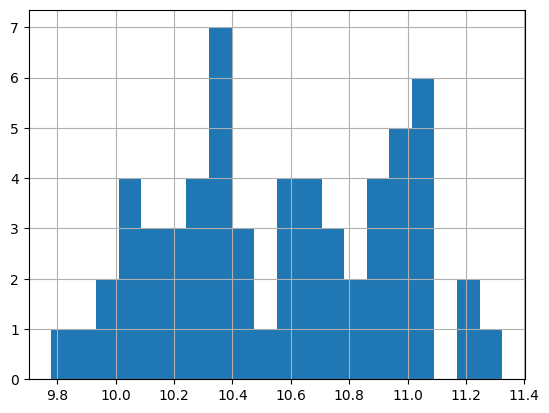

In [11]:
np.log(df['area']).hist(bins=20)

Попробуем для каждого временного ряда найти точку, где достигается максимум концентрации

In [12]:
M = []
for i in range(len(df)):
    x = [float(elem) for elem in df.drop('area', axis=1).columns]
    y = df.iloc[i,][:-1]
    M.append(x[np.argmax(y)])
df['max'] = M

Построим гистограмму для распределения этих точек

<Axes: >

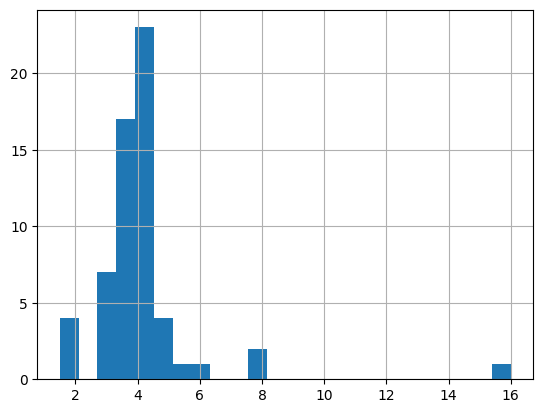

In [13]:
df['max'].hist(bins=len(df.columns) - 2)

In [14]:
m = df['max'].mean()
m

4.114

In [51]:
scipy.stats.normaltest(np.log(df['max']))

NormaltestResult(statistic=18.258297121021144, pvalue=0.00010845789112868627)

Как видно, среднее значение очень близко к моде

In [15]:
def check_fit(x, y, f1, f2, alpha=0.05, make_plots=True):
    m = x[np.argmax(y)]
    x1 = x[np.where(x <= m)]
    x2 = x[np.where(x >= m)]
    y1 = y[np.where(x <= m)]
    y2 = y[np.where(x >= m)]
    popt1, _ = scipy.optimize.curve_fit(f1, x1, y1)
    popt2, _ = scipy.optimize.curve_fit(f2, x2, y2)
    y_pred = np.array(list(f1(x1, *popt1))[:-1] + list(f2(x2, *popt2)))
    _, pvalue = scipy.stats.normaltest(y - y_pred)
    if make_plots:
        plt.plot(x, y)
        plt.plot(x, y_pred, color='red' if pvalue < alpha else 'green')
    plt.show()
    return pvalue, popt1, popt2

Попробуем использовать следующую модель для предсказания концентрации от времени:

$
f(x)=
\begin{cases}
ax^2 + bx + c, x < m \\\ 
e^{ax+b} (x^2 +cx + d), x \geq m
\end{cases}
$,   где $m$ - точка максимума концентрации

Здесь и далее, если коэффициент имеет индекс, то первый индекс означет, что это коэффициент для первой модели, в противном случае - для второй

In [16]:
def f1(x, a, b, c):
    return a * x ** 2 + b * x + c

In [17]:
def f2(x, a, b, c, d):
    return np.exp(a * x + b) * (x ** 2 + x * c + d)

In [18]:
pvalues = []
a1 = []
b1 = []
c1 = []
a2 = []
b2 = []
c2 = []
d2 = []

Проверим нашу модель на состоятельность

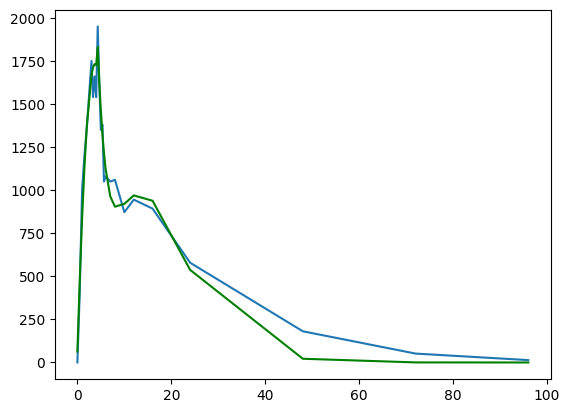

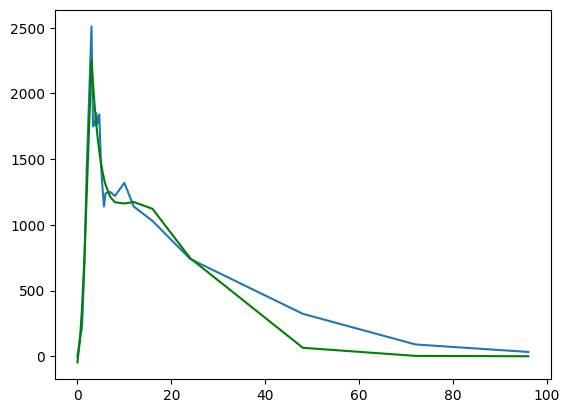

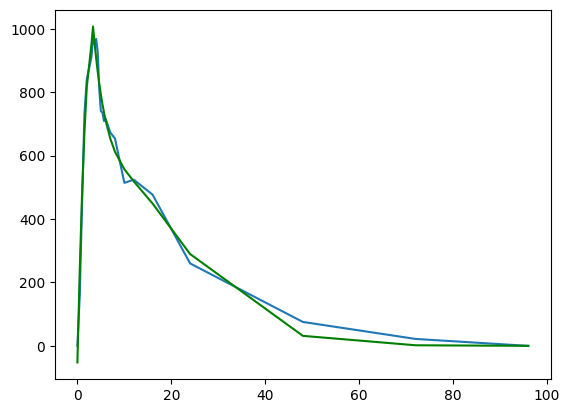

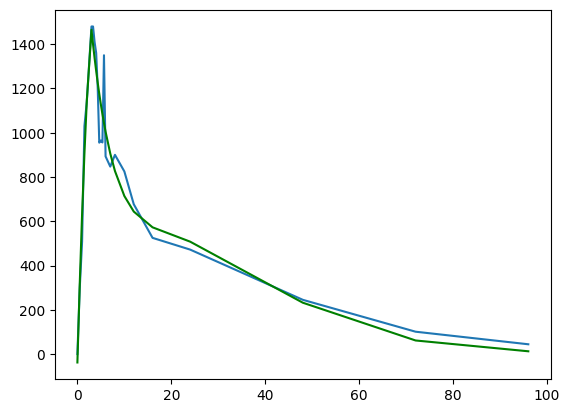

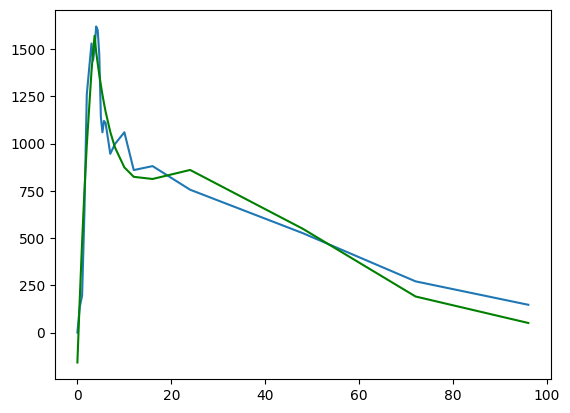

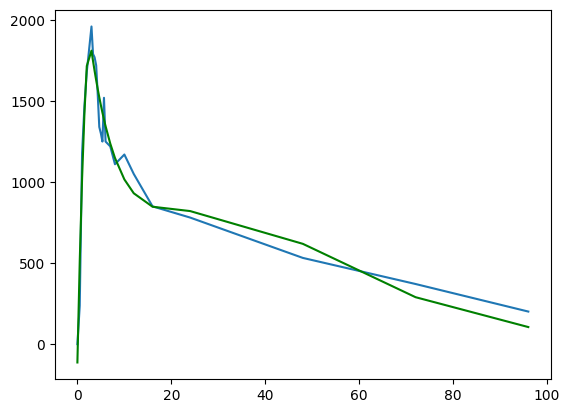

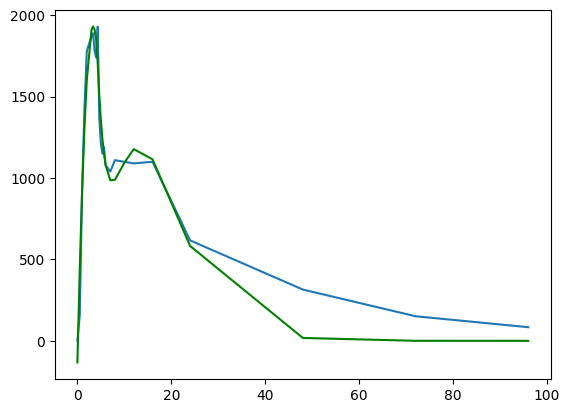

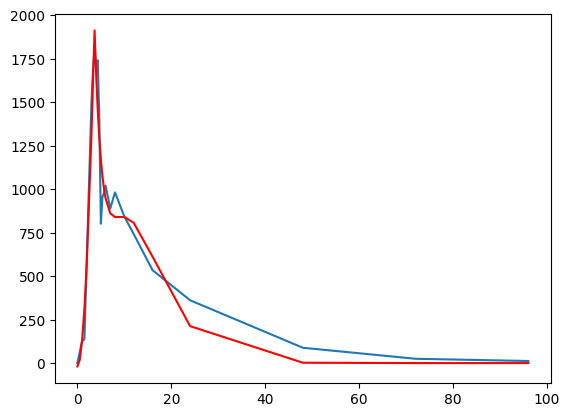

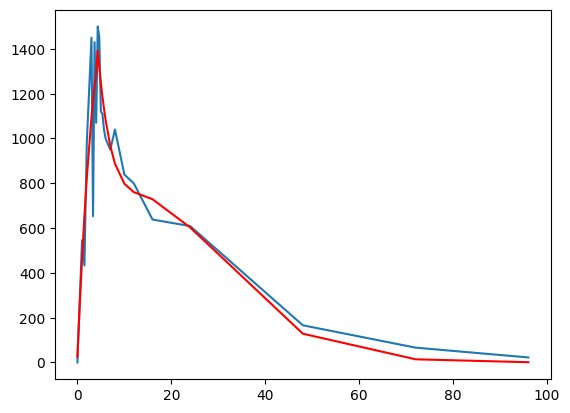

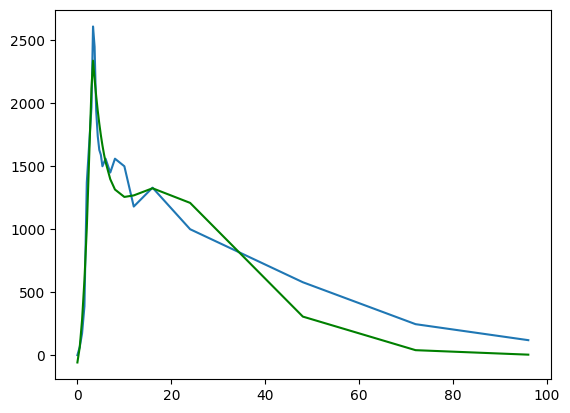

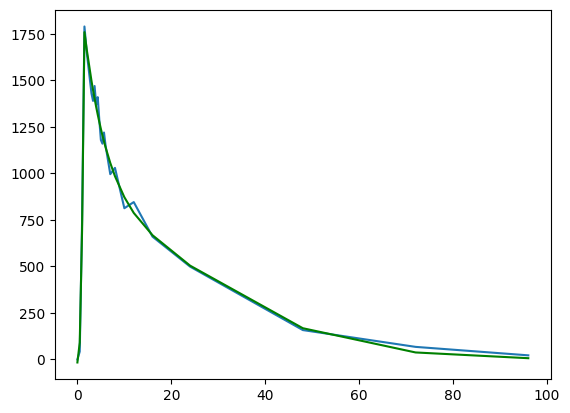

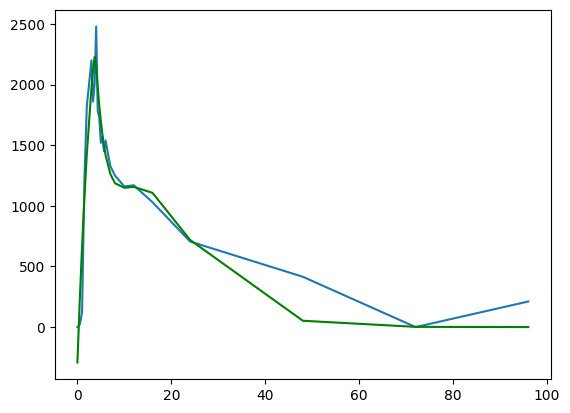

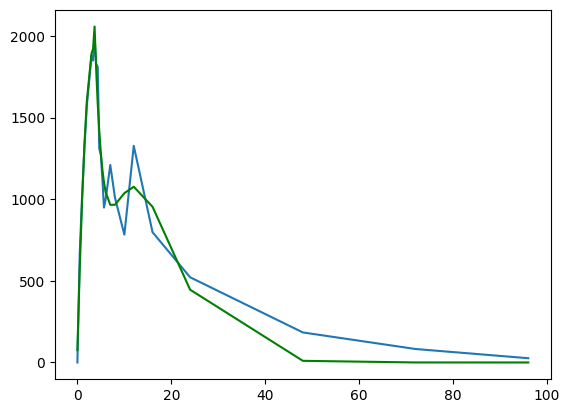

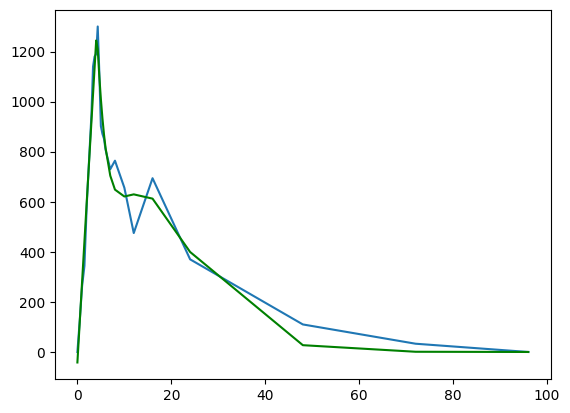

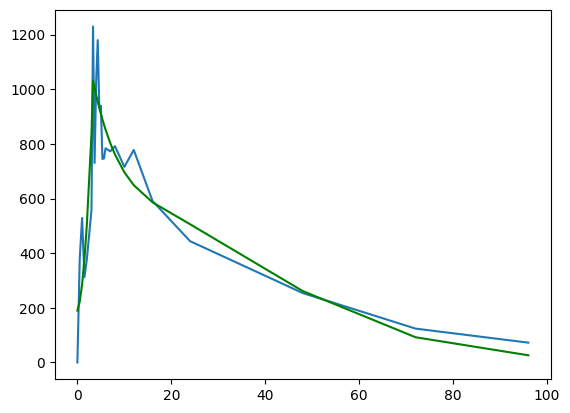

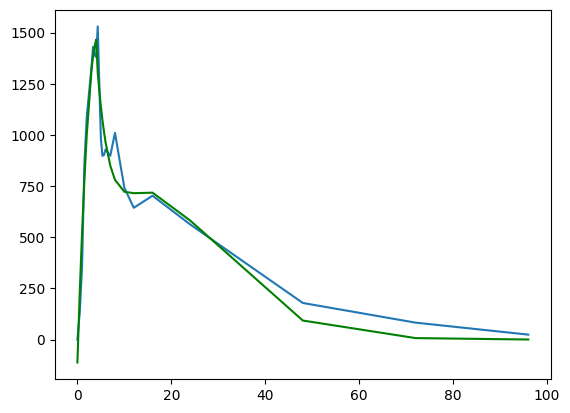

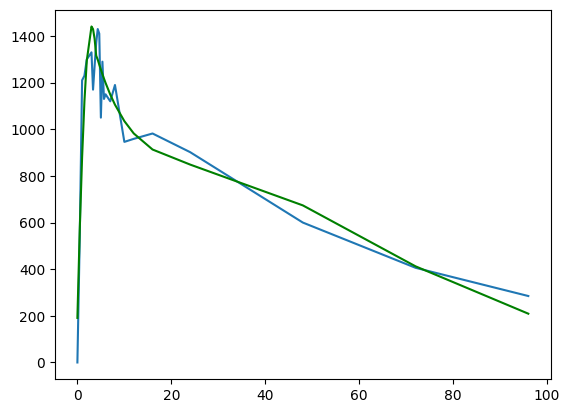

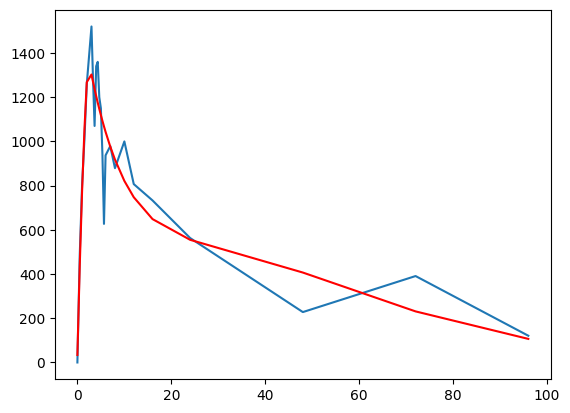

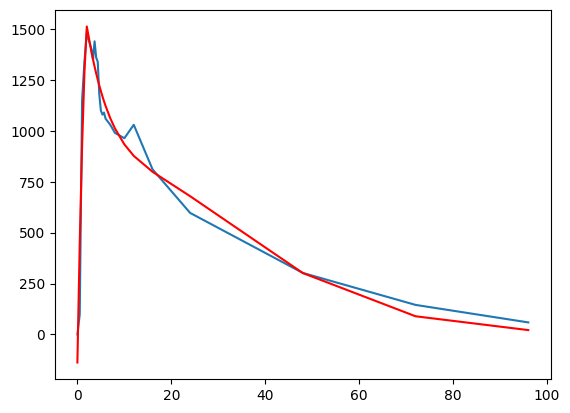

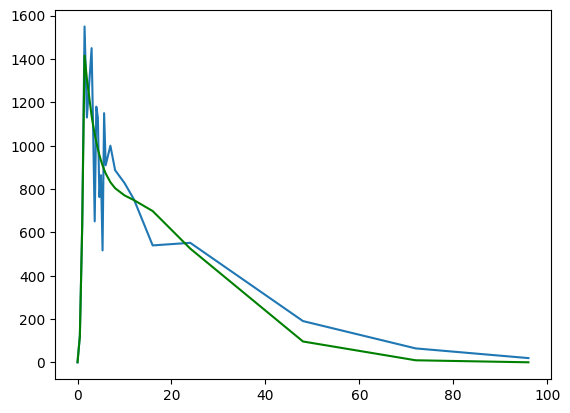

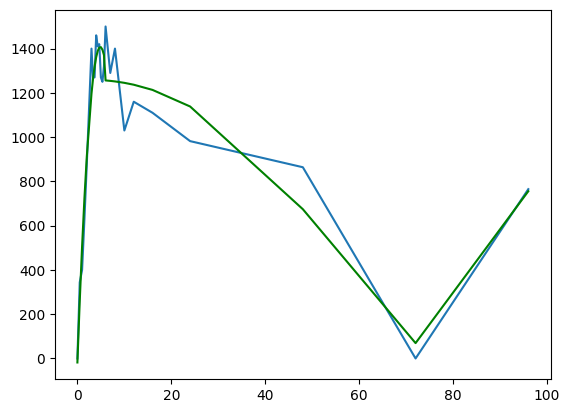

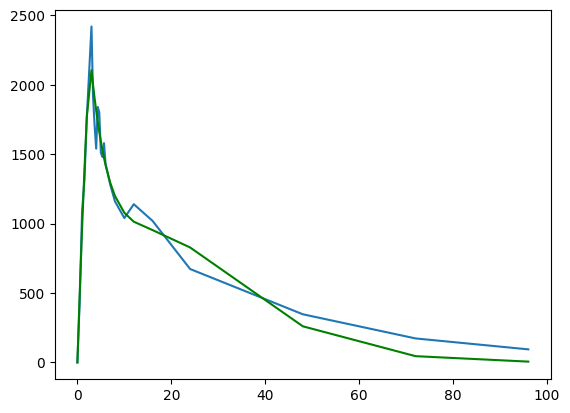

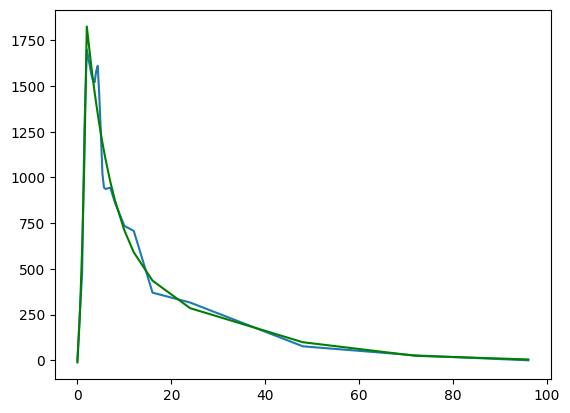

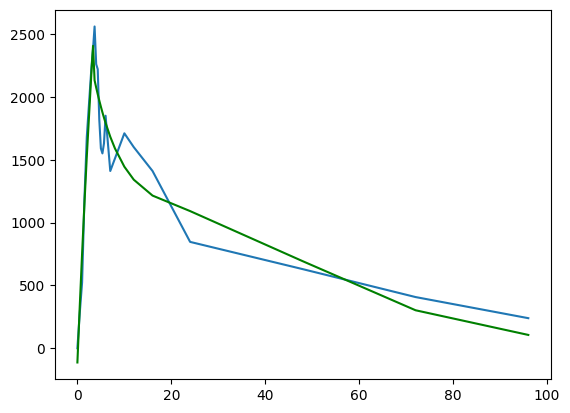

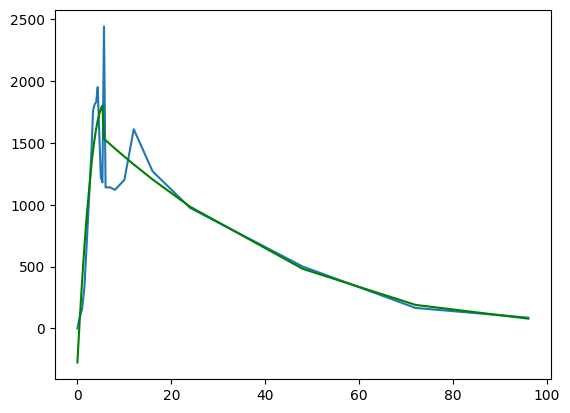

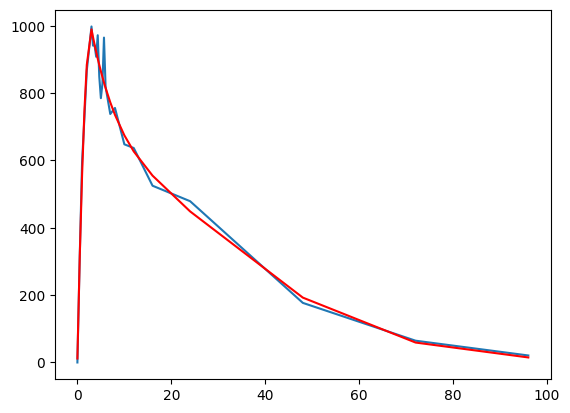

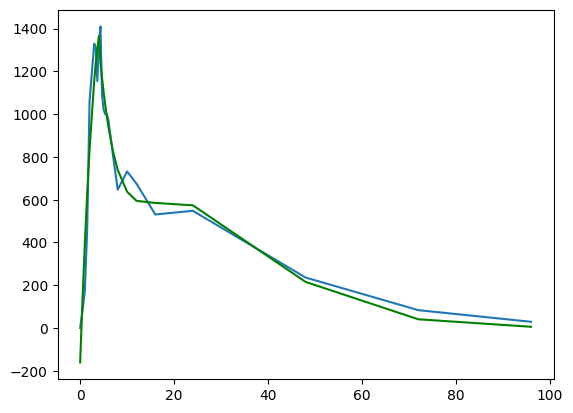

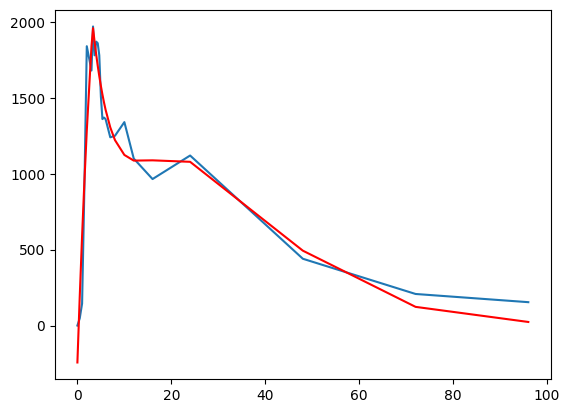

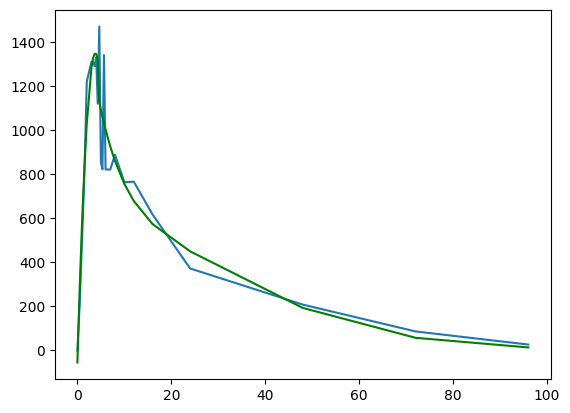

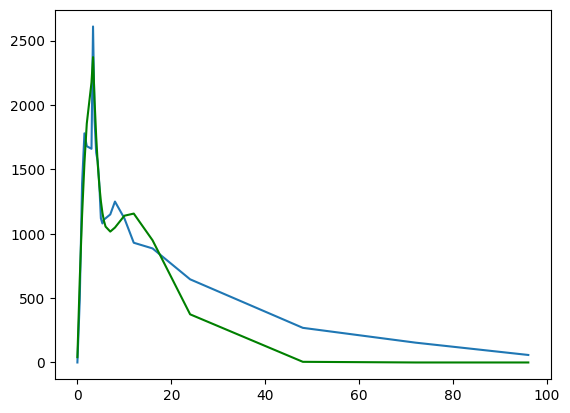

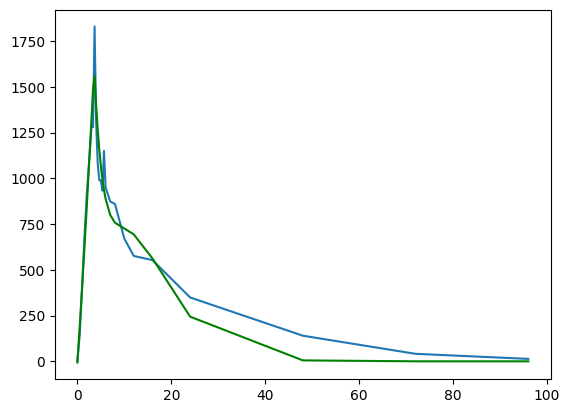

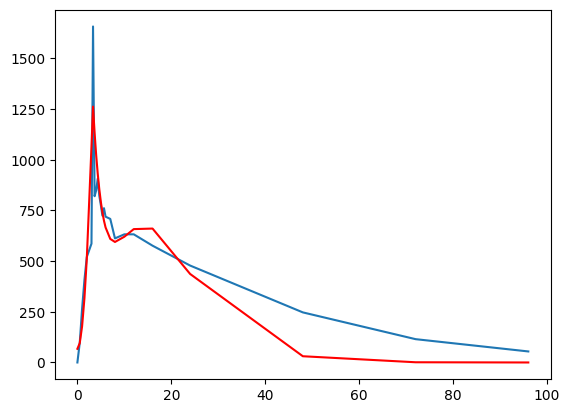

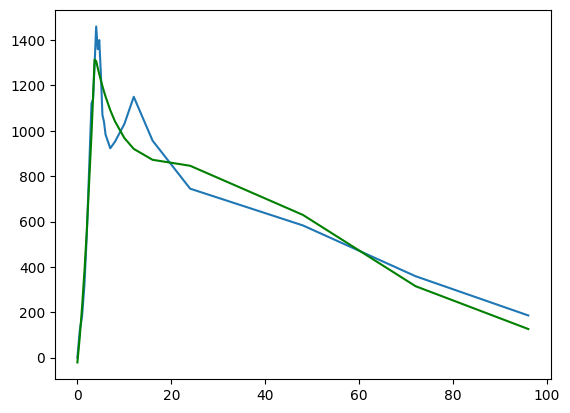

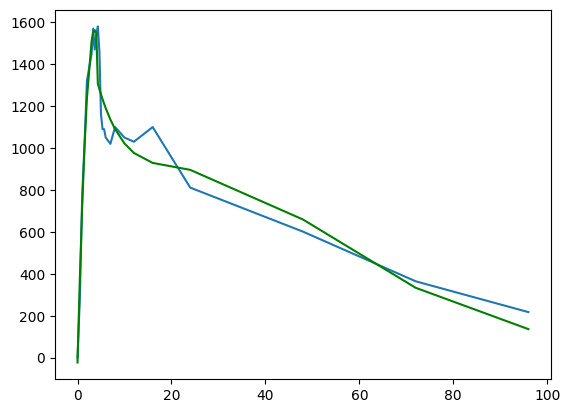

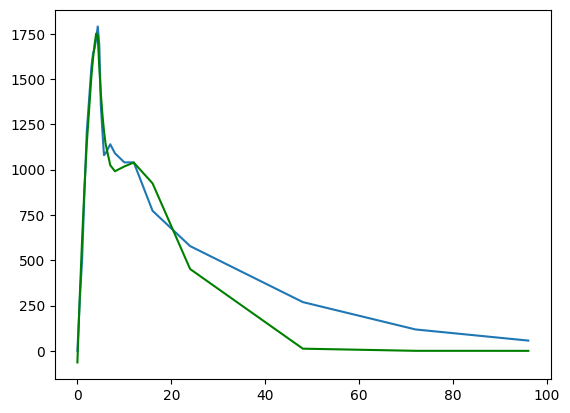

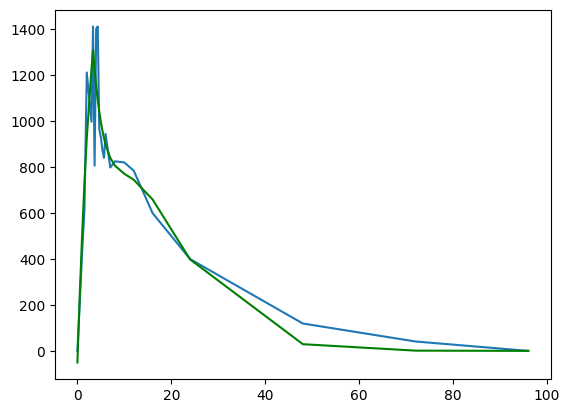

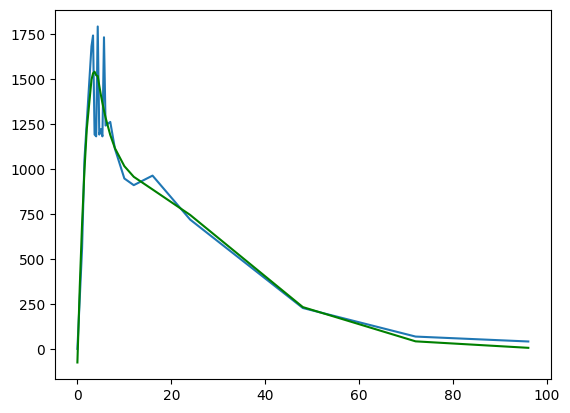

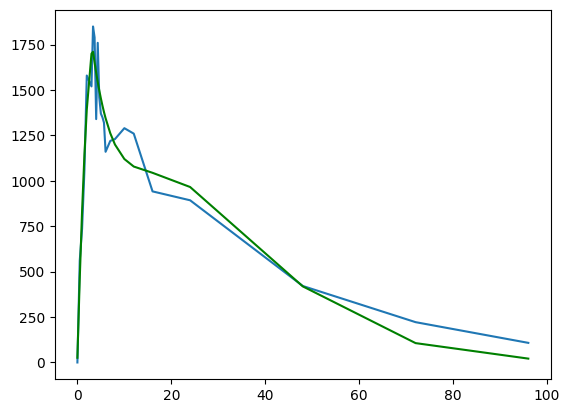

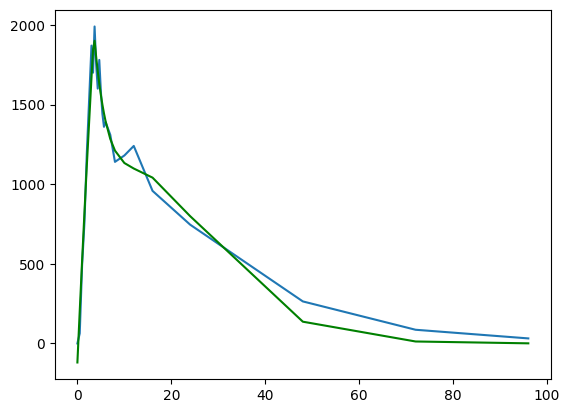

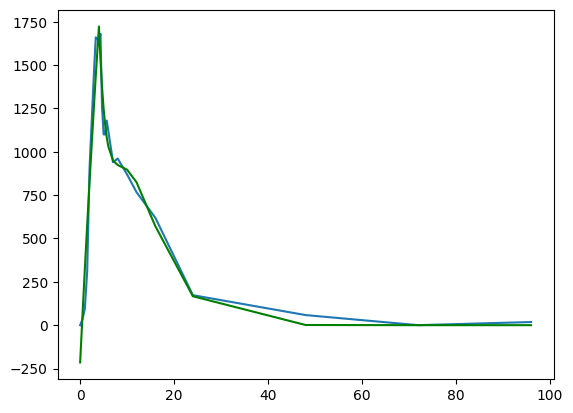

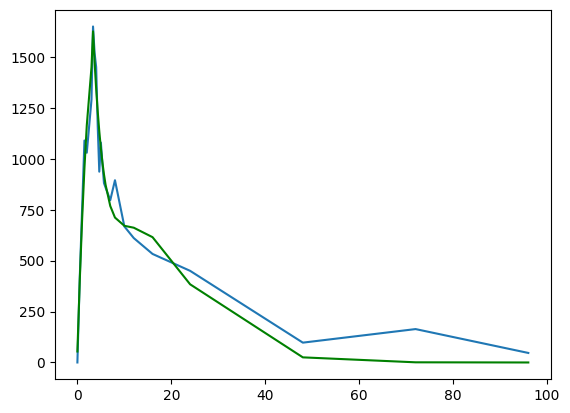

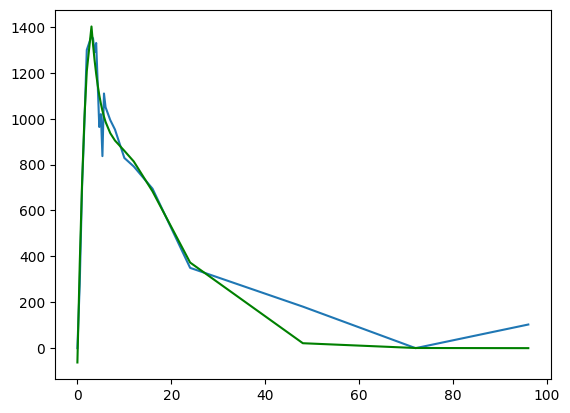

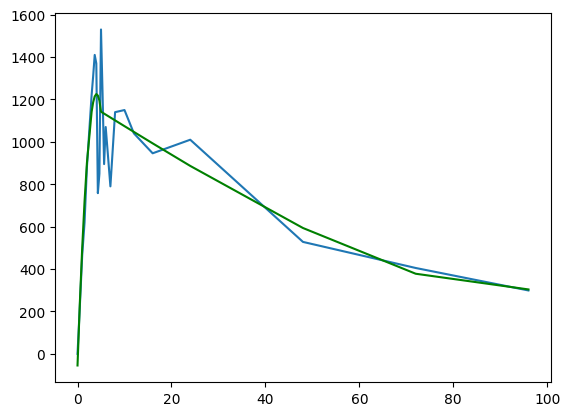

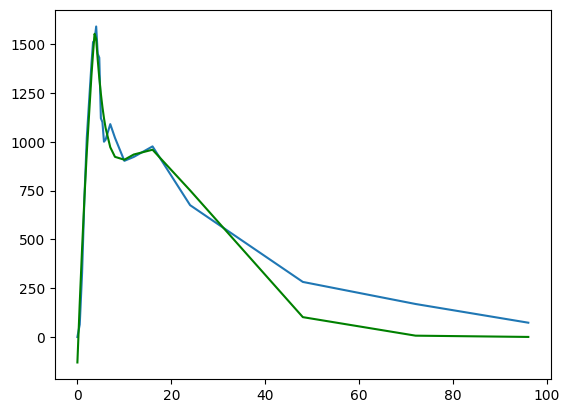

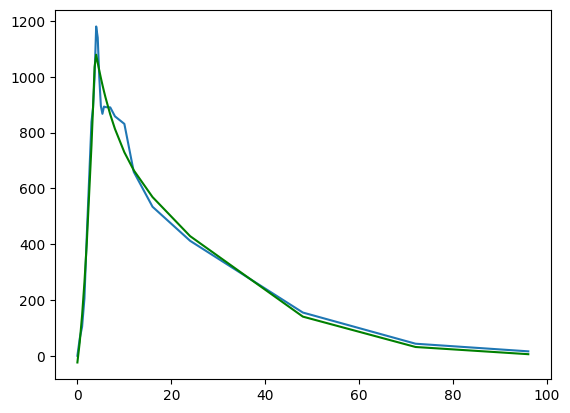

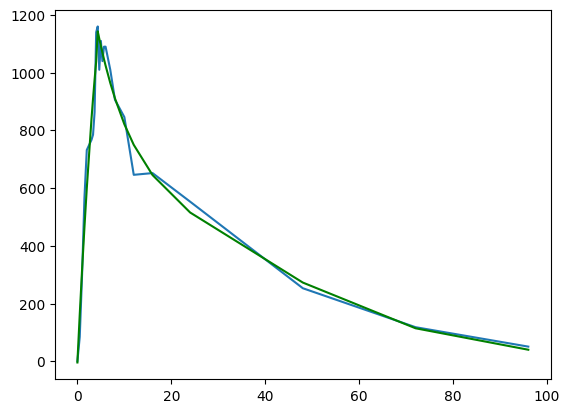

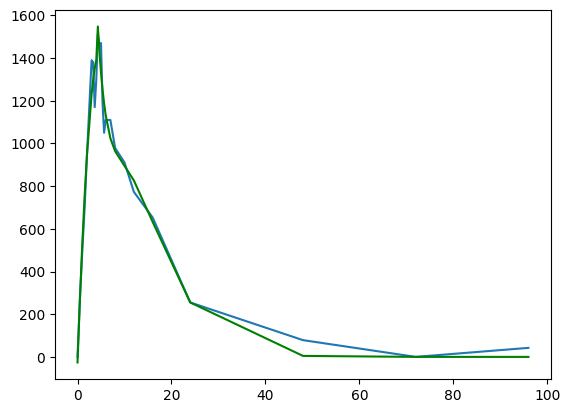

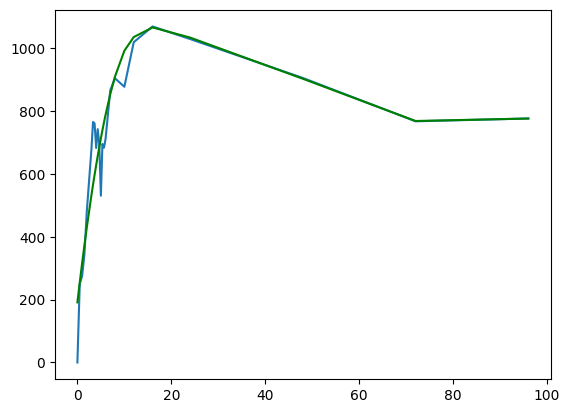

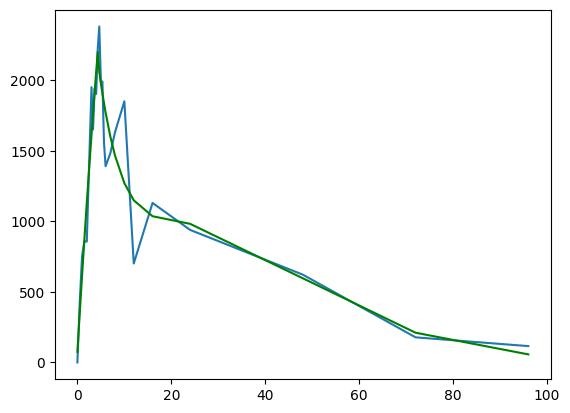

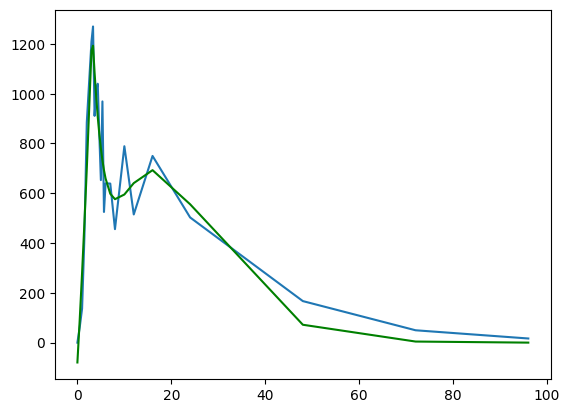

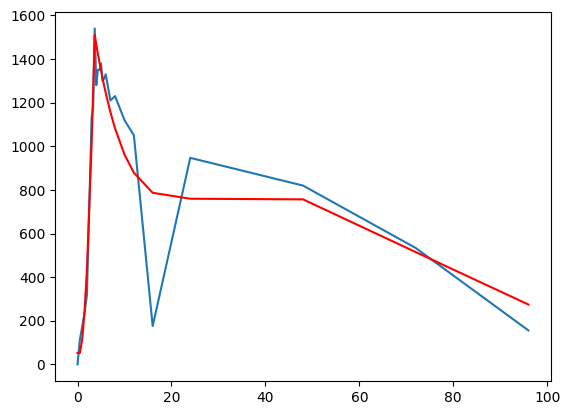

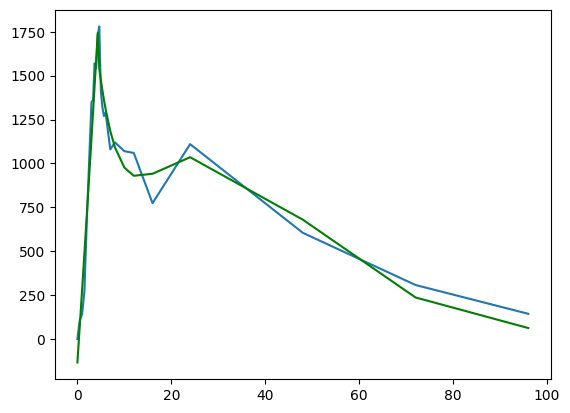

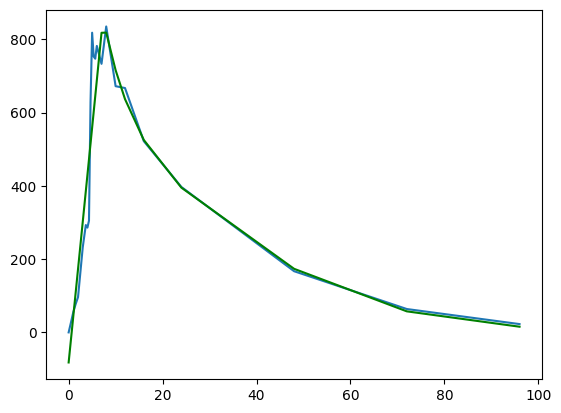

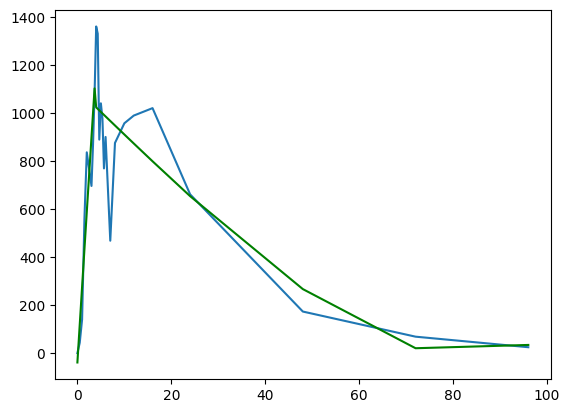

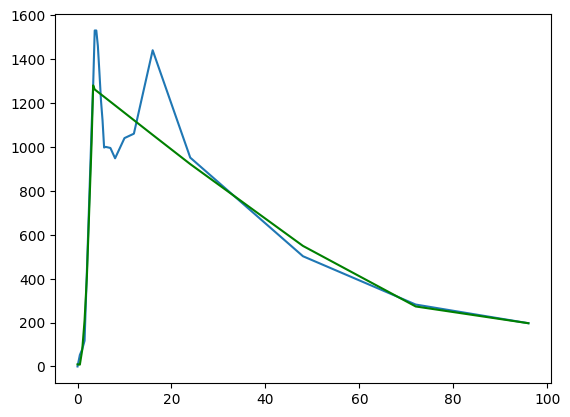

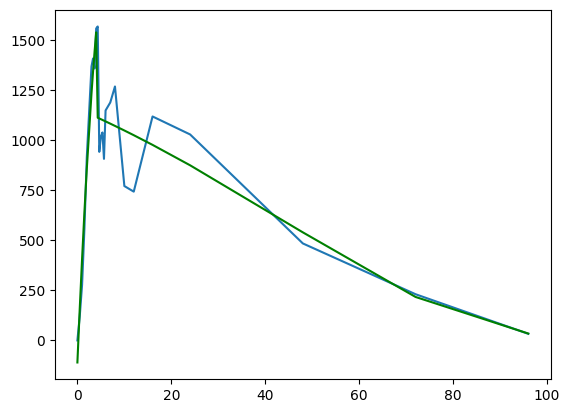

In [19]:
for i in range(len(df)):
    x = np.array([float(elem) for elem in df.drop(['area', 'max'], axis=1).columns])
    y = np.array(df.iloc[i,][:-2])
    try:
        pvalue, popt1, popt2 = check_fit(x, y, f1, f2, make_plots=True)
        pvalues.append(pvalue)
        a1_, b1_, c1_ = popt1
        a1.append(a1_)
        b1.append(b1_)
        c1.append(c1_)
        a2_, b2_, c2_, d2_ = popt2
        a2.append(a2_)
        b2.append(b2_)
        c2.append(c2_)
        d2.append(d2_)
    except RuntimeError:
        pass
a1 = np.array(a1)
b1 = np.array(b1)
c1 = np.array(c1)
a2 = np.array(a2)
b2 = np.array(b2)
c2 = np.array(c2)
d2 = np.array(d2)

Визуально модель выглядит как подходящая, посмотрим на значение теста на нормальность остатков

In [20]:
pvalues = np.array(pvalues)
success = pvalues > alpha
np.mean(success)

0.8571428571428571

То есть, примерно в 86% случаев остатки являются нормальными

Попробуем отследить связь между коэффициентами в моделях. Это может быть полезно как для упрощения, так и для предсказания модели.

In [21]:
def plot_with_sort(x, y):
    pairs = sorted(zip(x, y), key=lambda elem: elem[0])
    x = [elem[0] for elem in pairs]
    y = [elem[1] for elem in pairs]
    plt.plot(x, y)

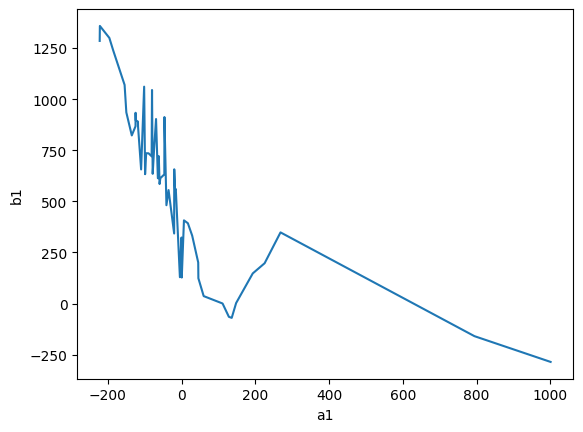

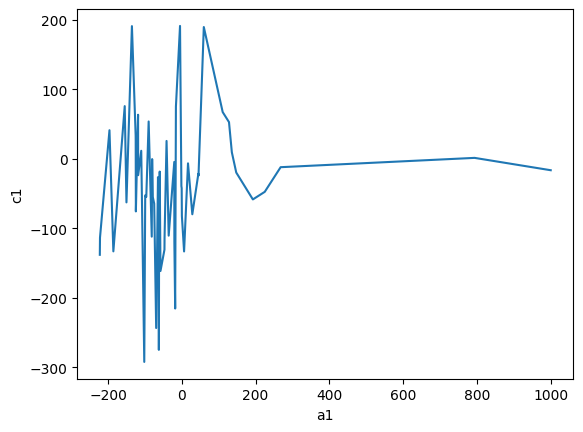

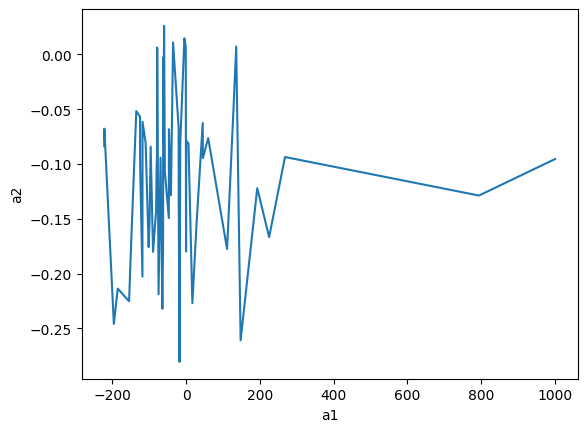

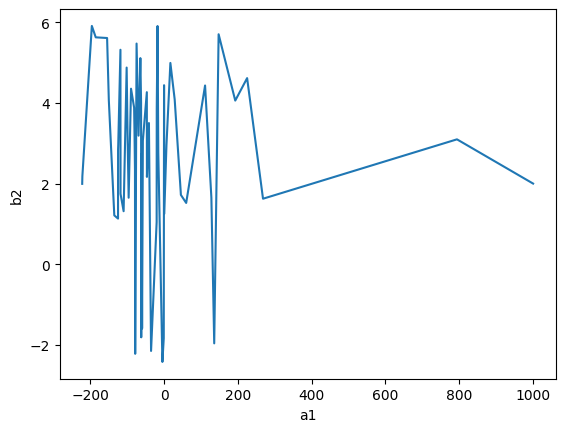

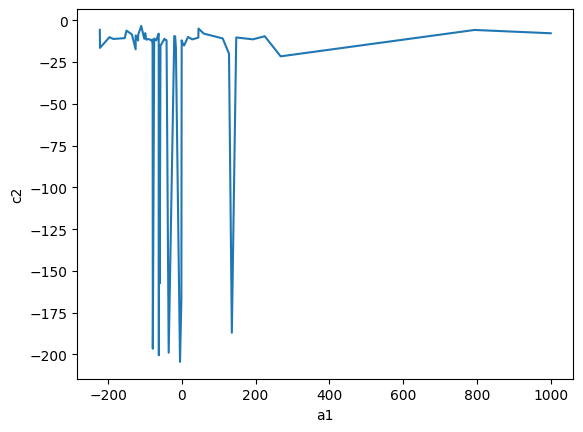

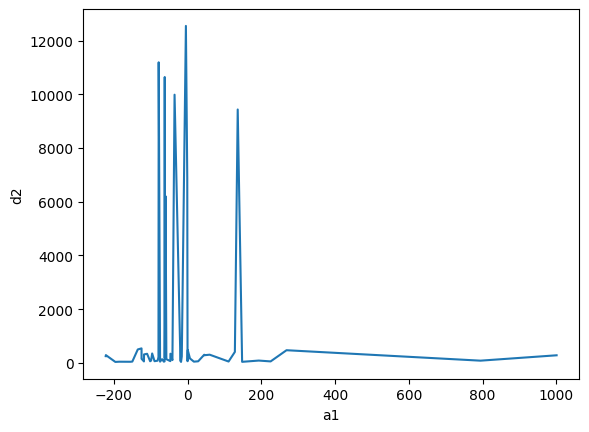

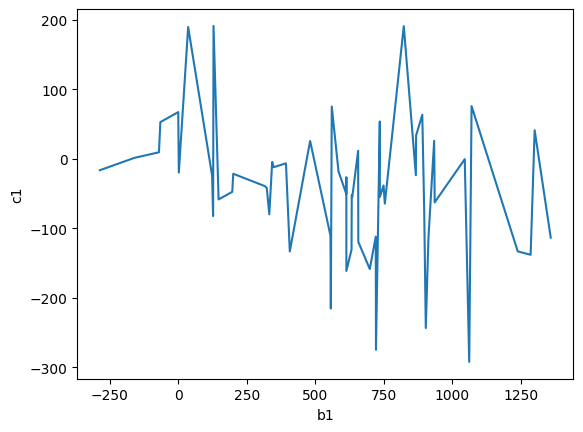

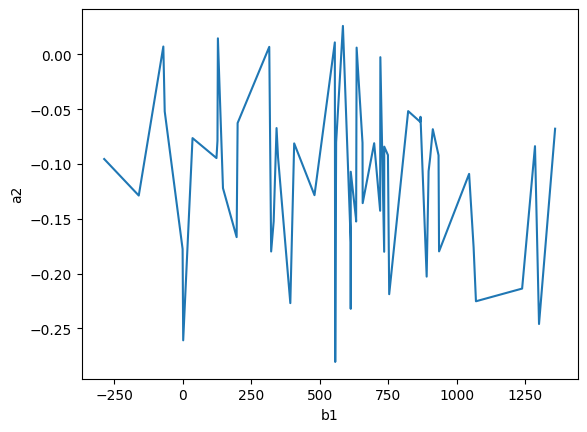

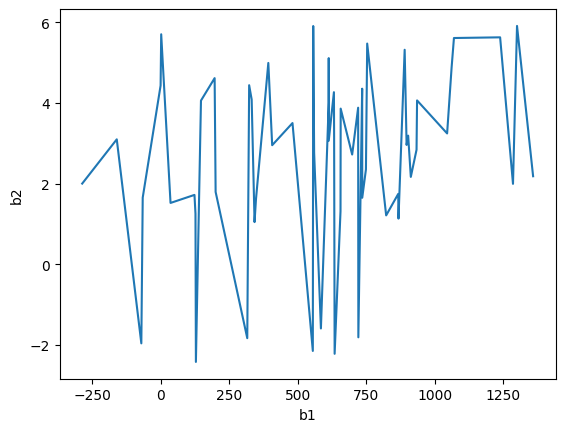

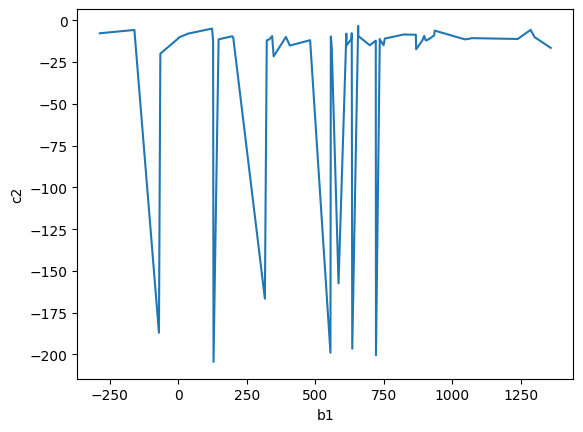

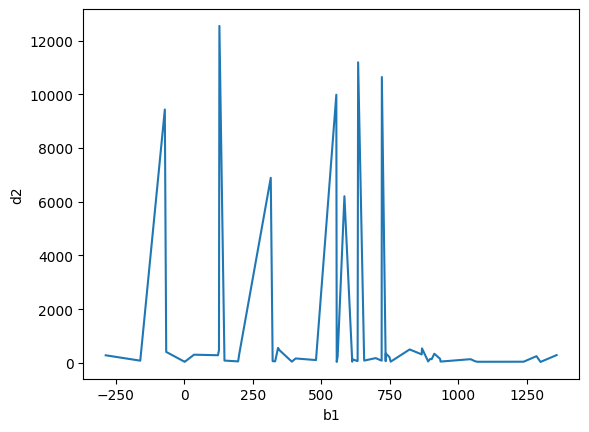

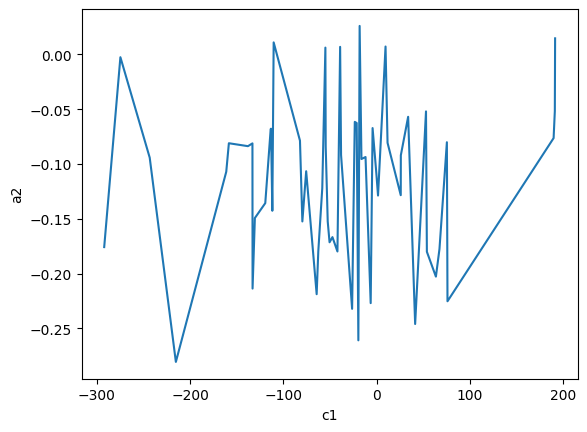

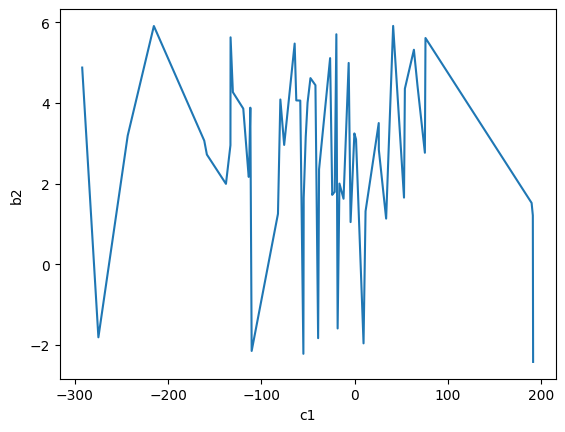

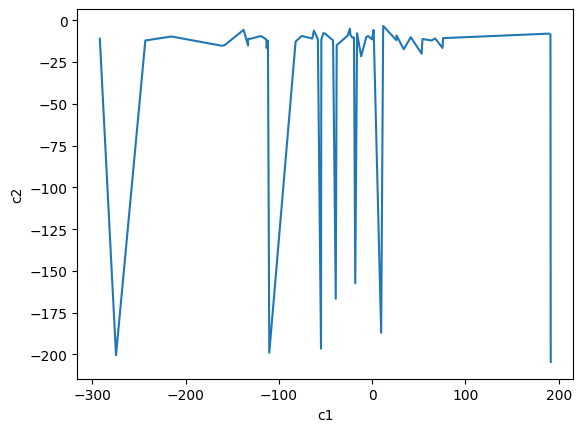

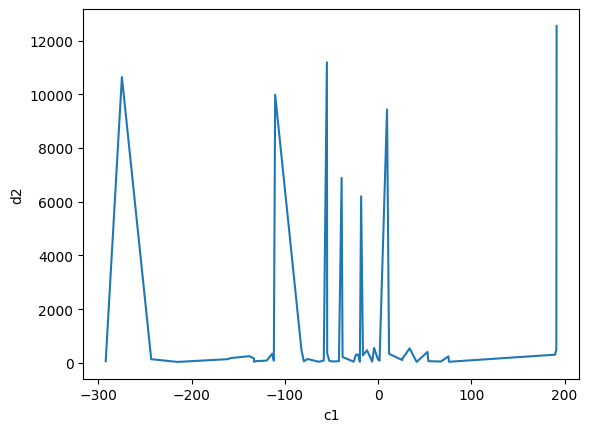

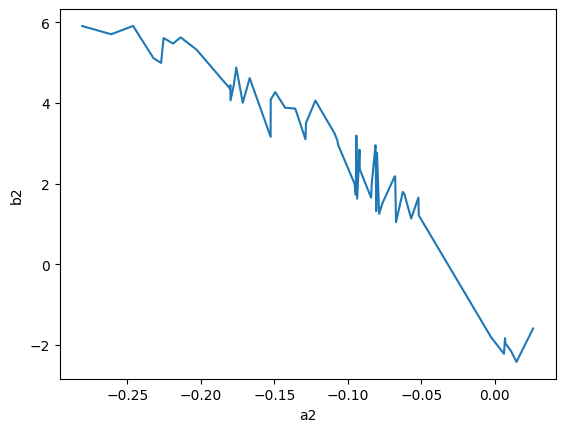

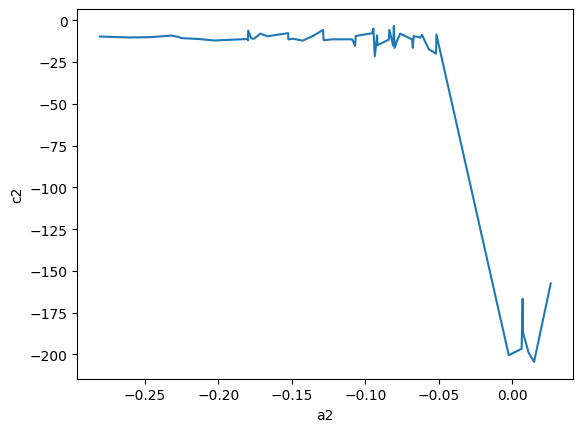

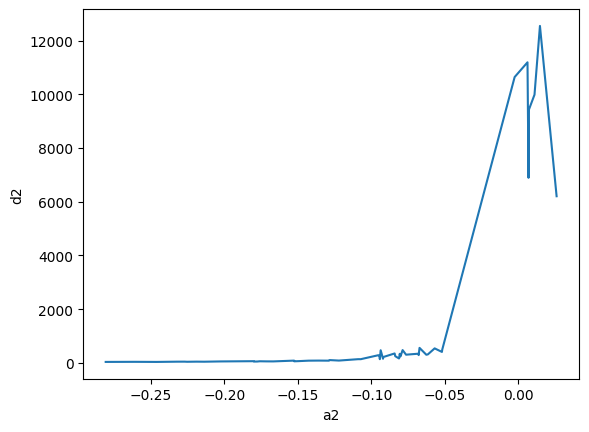

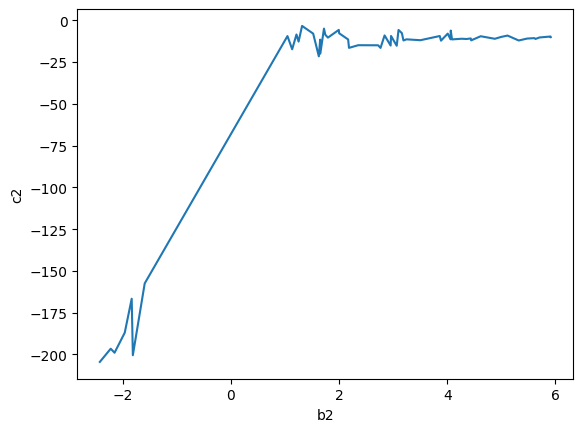

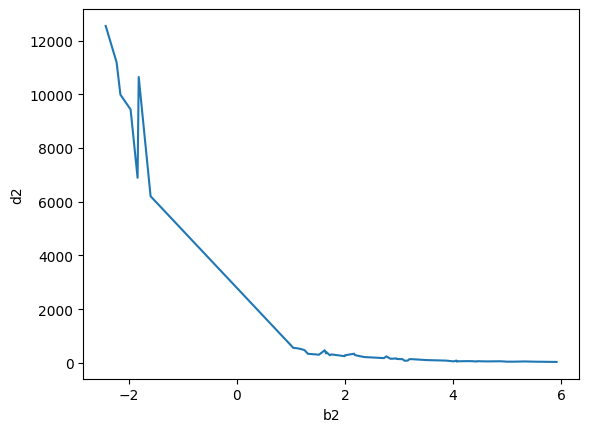

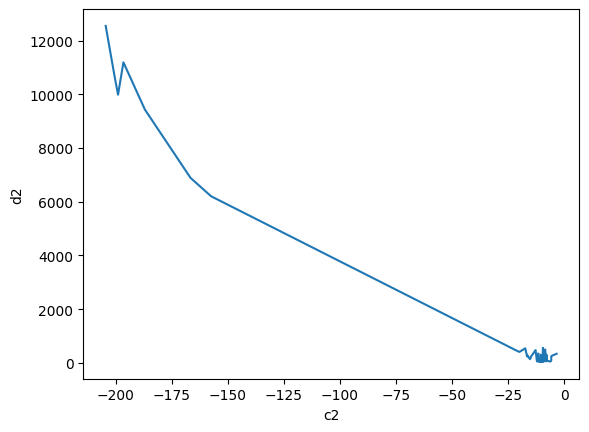

In [22]:
coords = {'a1': a1, 'b1': b1, 'c1': c1, 'a2': a2, 'b2': b2, 'c2': c2, 'd2': d2}
for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        x = list(coords.keys())[i]
        y = list(coords.keys())[j]
        plt.xlabel(x)
        plt.ylabel(y)
        plot_with_sort(coords[x], coords[y])
        plt.show()

Зависимость коэффициентов от  *_2 от b_1

In [23]:
x = b1
y1 = a2
y2 = b2
y3 = c2
y4 = d2

In [24]:
points = zip(x, y1, y2, y3, y4)

In [25]:
points = sorted(points, key=lambda elem: elem[0])

In [26]:
def get_col(table, col_number):
    return np.fromiter(map(lambda elem: elem[col_number] , table), dtype=float)

In [27]:
x = get_col(points, 0)
y1 = get_col(points, 1)
y2 = get_col(points, 2)
y3 = get_col(points, 3)
y4 = get_col(points, 4)

[Text(0.5, 0, 'b1'), Text(0, 0.5, 'd2')]

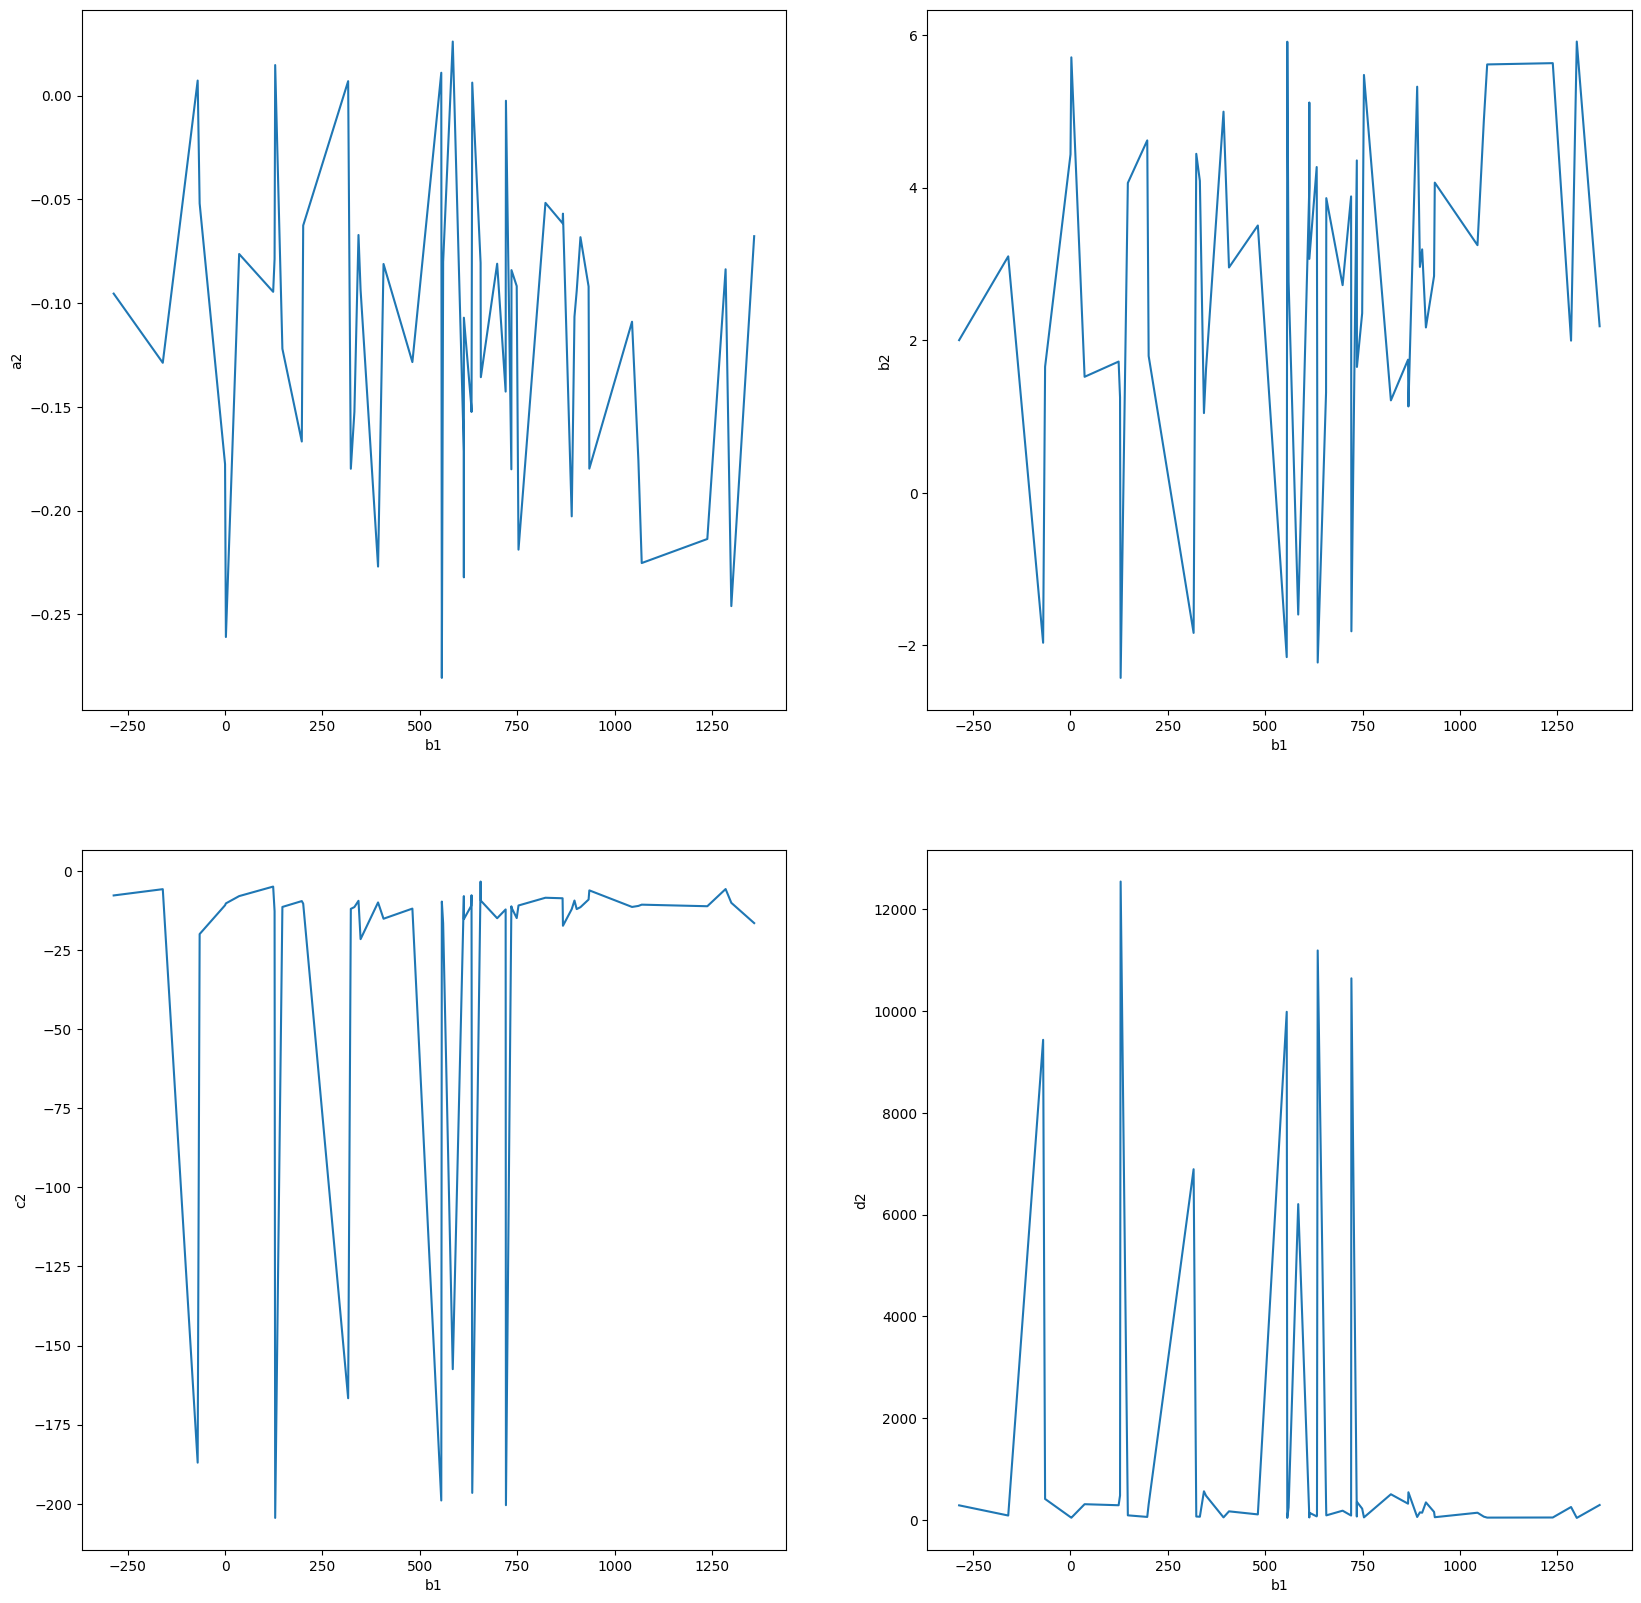

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].plot(x, y1)
axs[0, 0].set(xlabel='b1', ylabel='a2')

axs[0, 1].plot(x, y2)
axs[0, 1].set(xlabel='b1', ylabel='b2')

axs[1, 0].plot(x, y3)
axs[1, 0].set(xlabel='b1', ylabel='c2')

axs[1, 1].plot(x, y4)
axs[1, 1].set(xlabel='b1', ylabel='d2')

На графиках можно видеть сегменты, где $b_1 < 0$ и $b_1 \geq 0$. В первом случае виден линейный характер зависимости. Пока исследуем вторую половину.

In [29]:
len(set(b1))

56

In [30]:
(x == y2).all()

False

То есть, $b_1$ и $b_2$ полностью идентичны

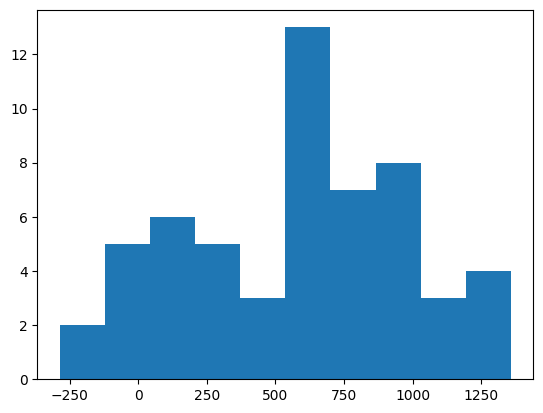

In [31]:
plt.hist(x)
plt.show()

Заметим, что большая часть значений лежит правее нуля. Значит, можно считать всё, что левее нуля, выбросами.

In [32]:
y1 = y1[x >= 0]
y2 = y2[x >= 0]
y3 = y3[x >= 0]
y4 = y4[x >= 0]
x = x[x >= 0]

[Text(0.5, 0, 'b1'), Text(0, 0.5, 'd2')]

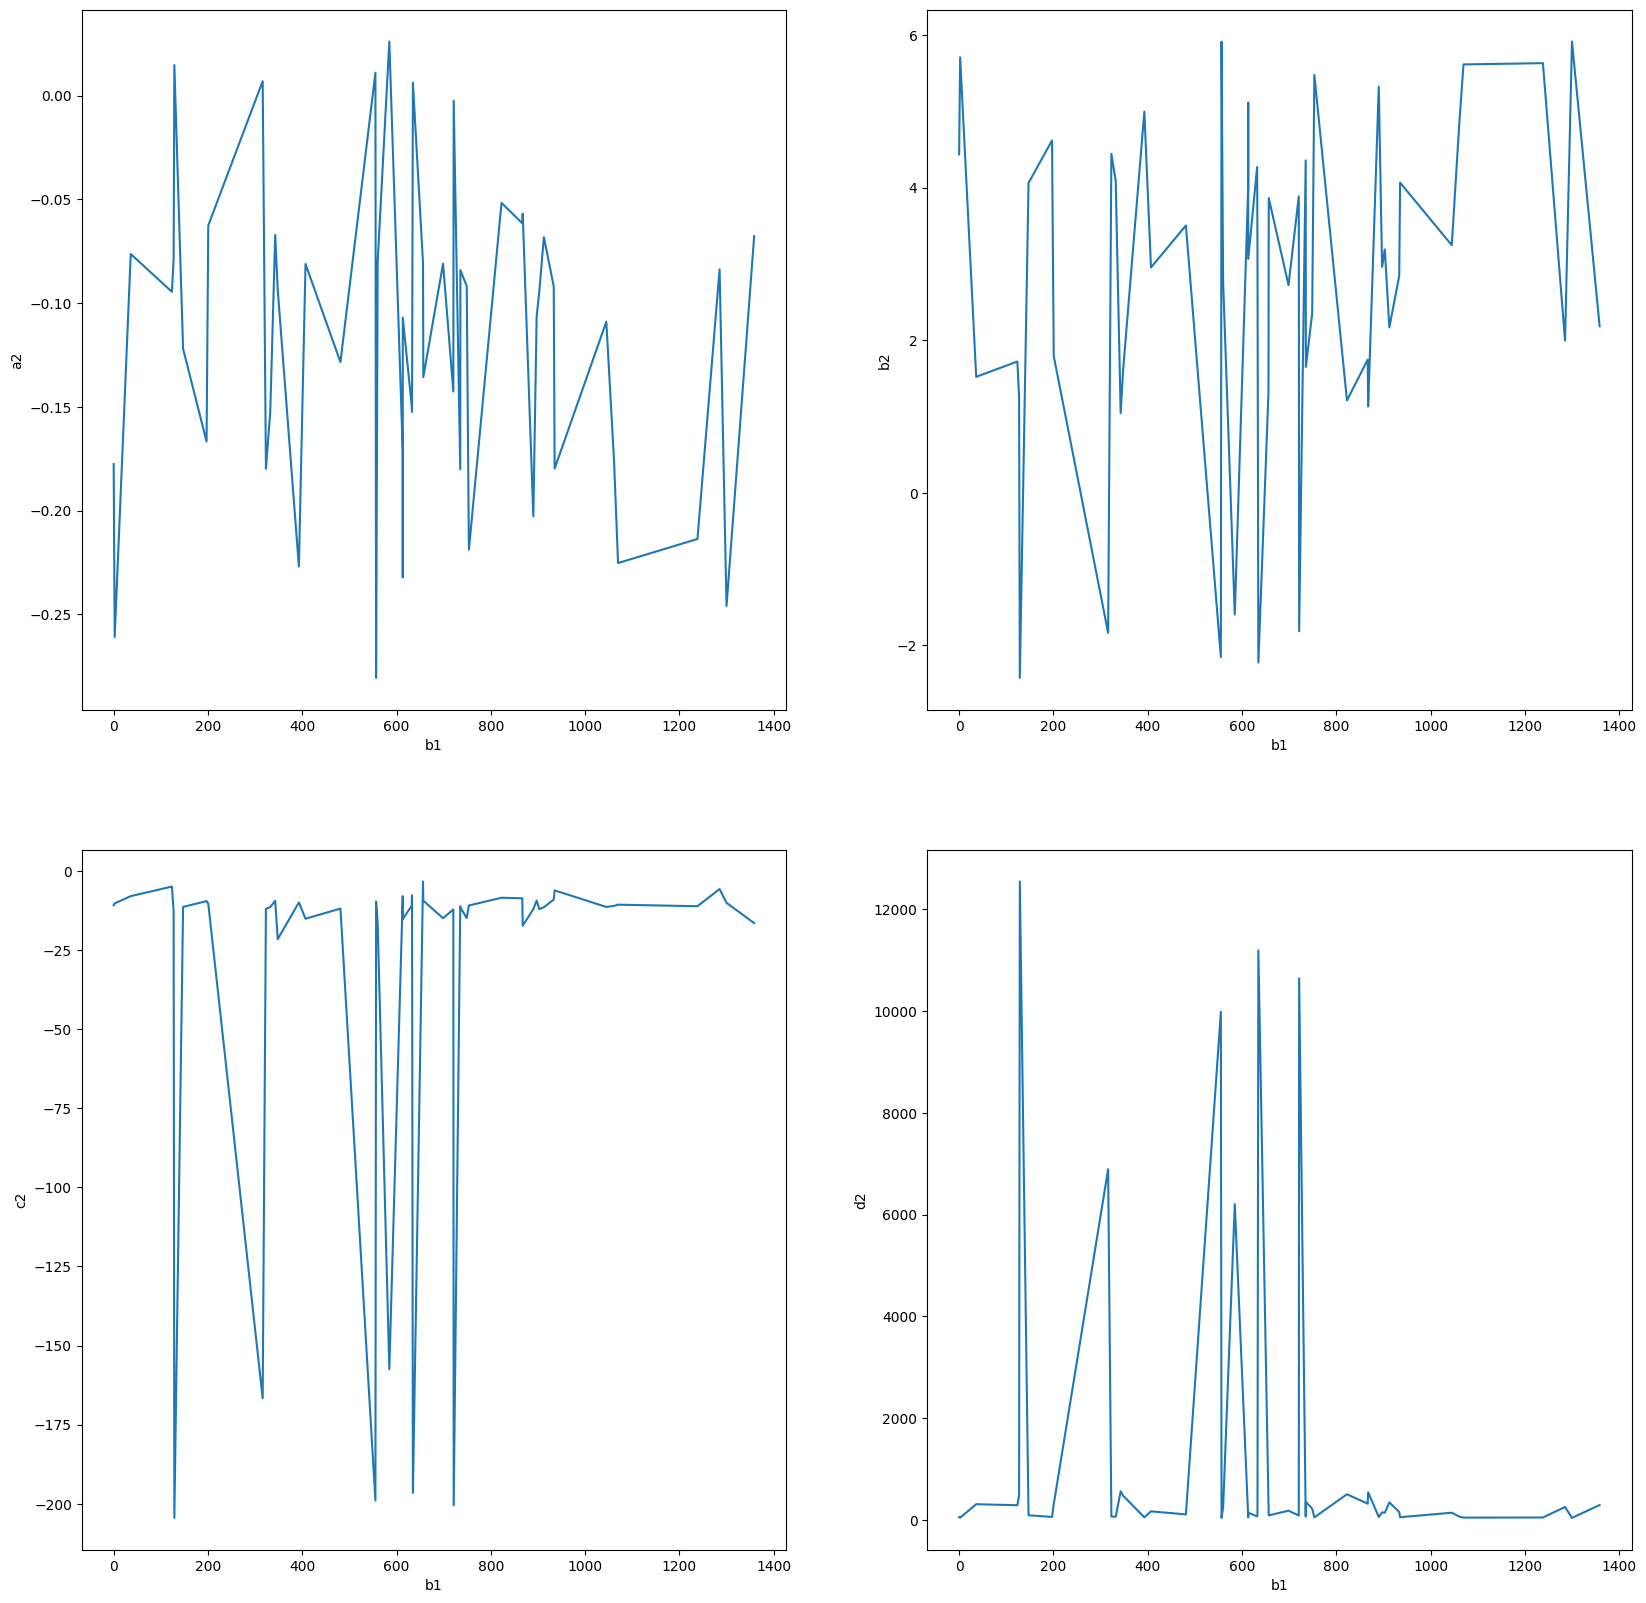

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].plot(x, y1)
axs[0, 0].set(xlabel='b1', ylabel='a2')

axs[0, 1].plot(x, y2)
axs[0, 1].set(xlabel='b1', ylabel='b2')

axs[1, 0].plot(x, y3)
axs[1, 0].set(xlabel='b1', ylabel='c2')

axs[1, 1].plot(x, y4)
axs[1, 1].set(xlabel='b1', ylabel='d2')

Исследуем зависимость $a_2$, $b_2$ и $d_2$ от $b_1$

In [34]:
def fa(x, a, b, c):
    return a * x **2 + b * x + c

In [35]:
def fb(x, params):
    return x

In [36]:
def fc(x, *params):
    return np.mean(c2)

In [37]:
def fd(x, a, b, c):
    return a / x ** b + c

In [38]:
def check_model(xdata, ydata, model, plot=True):
    params, cov = scipy.optimize.curve_fit(model, xdata, ydata)
    ydata_pred = model(x, *params)
    if plot:
        plt.plot(x, ydata)
        plt.plot(x, ydata_pred)
        print(params)
    plt.show()
    _, pvalue = scipy.stats.normaltest(ydata - ydata_pred)
    return params, pvalue, pvalue > alpha, np.sqrt(np.diag(cov))

**Коэффициент $a_2$**

[-8.24443053e-08  8.29794590e-05 -1.27702937e-01]


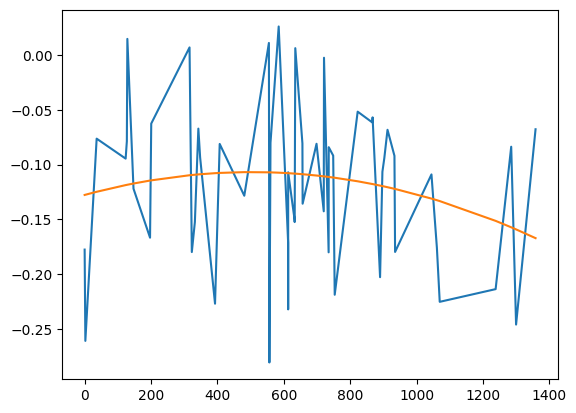

In [39]:
params1, _, _, _ = check_model(x, y1, fa)

**Коэффициент $b_2$**

[1.]


/tmp/ipykernel_3155/2061424025.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = scipy.optimize.curve_fit(model, xdata, ydata)


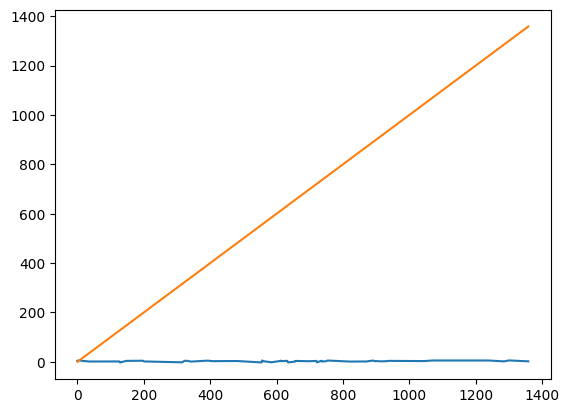

In [40]:
params2, _, _, _ = check_model(x, y2, fb)

Из графика не видно какой-либо зависимости между $b_1$ и $c_2$. Попробуем посмотреть на распределение $c_2$

**Коэффициент $c_2$**

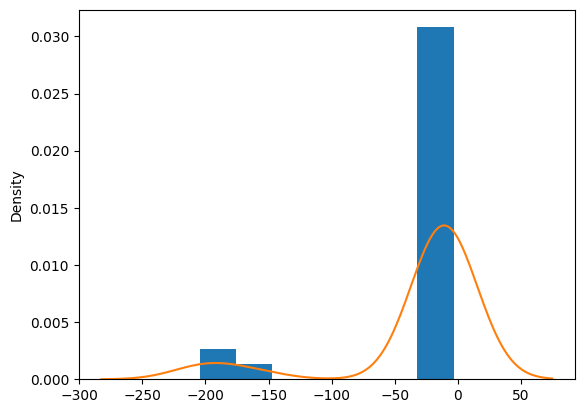

In [41]:
plt.hist(y3, bins=7, density=True)
sns.kdeplot(y3)
plt.show()

Здесь видно унимодальное распределение. Попробуем угадать какое именно мы тут имеем. Сначала проверим на количество уникальных значений

In [42]:
len(set(y3)), len(y3)

(52, 52)

Отсюда видно, что все значения в выборке уникальные. Теперь будем пробовать различные абсолютно-непрерывные распределения. Притом, у нас всего 49 значений в выборке, а значит нам понадобится критерий с достаточно большой скоростью сходимости. Возьмём критерий Колмогорова-Смринова и будем перебирать различные распределения.

In [43]:
_, pvalue = scipy.stats.kstest(y3, 'norm')
pvalue

4.884759376420634e-179

Отсюда видно, что распределение очевидно не является нормальным

In [44]:
_, pvalue = scipy.stats.kstest(y3, scipy.stats.laplace.cdf)
pvalue

2.515497199487834e-92

Распределение Лапласа также не подходит

In [45]:
_, pvalue = scipy.stats.kstest(np.log(-y3), scipy.stats.norm.cdf)
pvalue

2.520055289666376e-59

Логнормальное распределение не подошло

**Коэффициент $d_2$**

[-6.70996791e-05 -2.40618498e+00  1.80889489e+03]


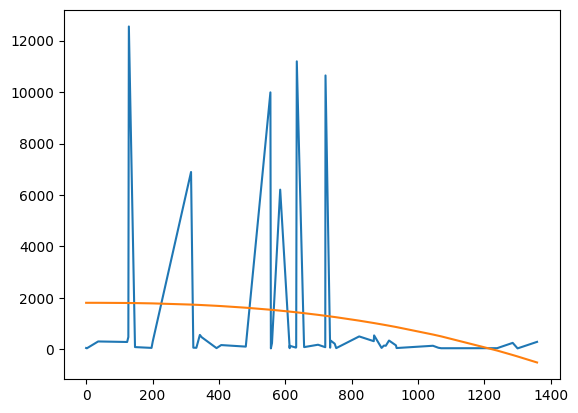

In [46]:
params4, _, _, _ = check_model(x, y4, fd)

In [47]:
y1_pred = fa(x, *params1)
y2_pred = fb(x, *params2)
y4_pred = fd(x, *params4)

Упрощаем нашу модель:

In [48]:
def new_check_fit(x, y, func1, func2, make_plots=True):
    m = x[np.argmax(y)]
    x1 = x[np.where(x <= m)]
    y1 = y[np.where(x <= m)]
    x2 = x[np.where(x >= m)]
    y2 = y[np.where(x >= m)]
    popt1, _ = scipy.optimize.curve_fit(func1, x1, y1)
    popt2, _ = scipy.optimize.curve_fit(func2, x2, y2)
    _, b1_, _ = popt1
    a2_ = fa(b1_, *params1)
    b2_ = fb(b1_, *params2)
    c2_ = fc(b1_)
    d2_ = fd(b1_, *params4)
    popt2_est = a2_, b2_, c2_, d2_
    y_pred = np.array(list(func1(x1, *popt1))[:-1] + list(func2(x2, *popt2)))
    _, pvalue = scipy.stats.normaltest(y - y_pred)
    print(popt2, popt2_est, sep='\n')
    if make_plots:
        plt.plot(x, y)
        plt.plot(x, y_pred, color='red' if pvalue < alpha else 'green')
        plt.show()

[ -0.2027442    5.32138129 -12.09913685  55.15652164]
(-0.11915835794442635, 890.047118523676, -33.07645437620301, 970.2971200396667)


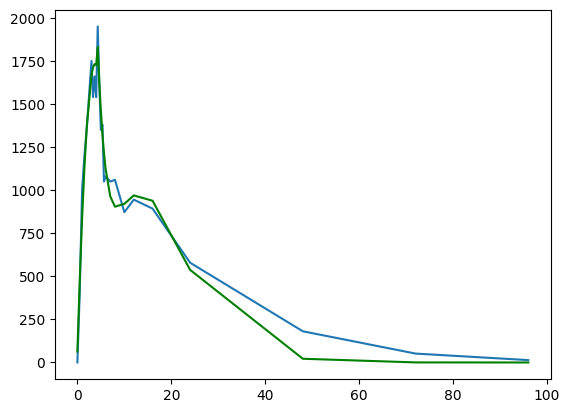

[-0.16668106  4.61766026 -9.55133513 56.32639302]
(-0.11455123695775837, 197.0857186045215, -33.07645437620301, 1786.6061622312782)


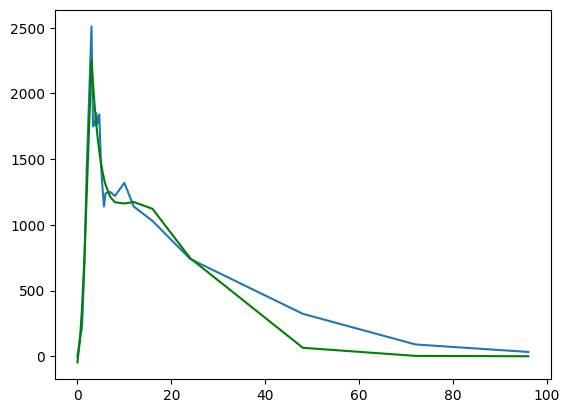

[-0.15244528  3.16041225 -7.70378753 85.52504611]
(-0.10820749829773138, 632.8144212459955, -33.07645437620301, 1439.8241892195322)


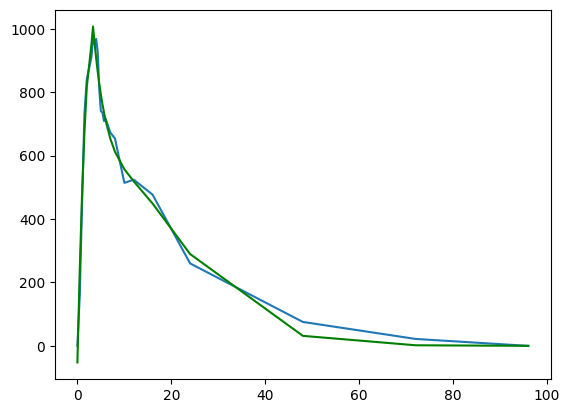

[-9.17910920e-02  2.35300785e+00 -1.49205065e+01  2.19211450e+02]
(-0.1117957158090416, 748.8285685104322, -33.07645437620301, 1255.5241185441387)


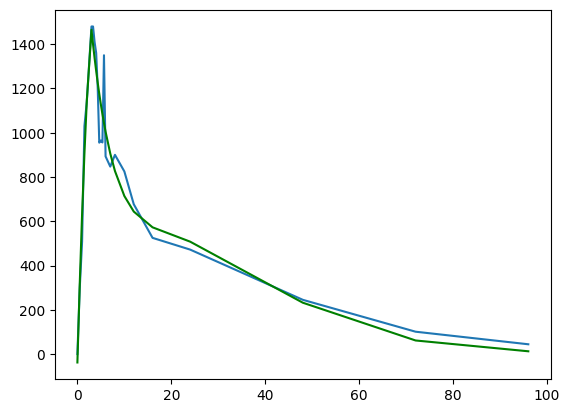

[-8.10044747e-02  2.72095155e+00 -1.49683777e+01  1.79011327e+02]
(-0.109970639437655, 698.6270665805325, -33.07645437620301, 1340.6198321998038)


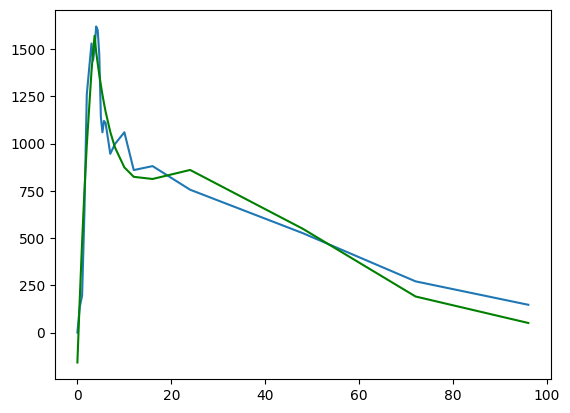

[-6.77356203e-02  2.18236010e+00 -1.65093005e+01  2.90756735e+02]
(-0.1671180682398206, 1358.4285628651926, -33.07645437620301, -510.56328892215424)


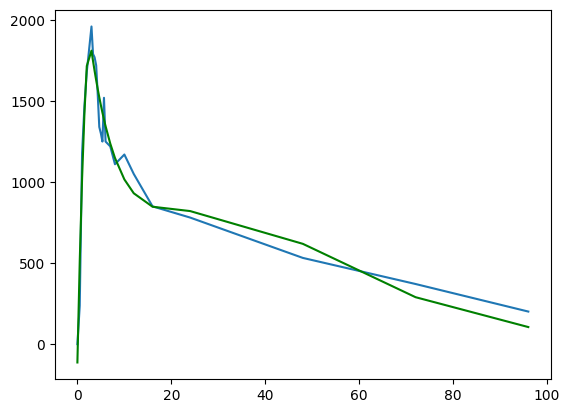

[ -0.21365403   5.62982365 -11.18046266  45.06212617]
(-0.15135044344469, 1238.1510880357405, -33.07645437620301, -46.797271281373014)


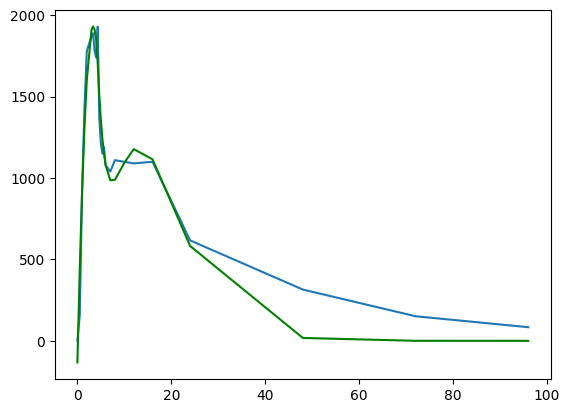

[ -0.26089188   5.70585372 -10.28185292  40.75670838]
(-0.12751888506879253, 2.222954226203683, -33.07645437620301, 1808.8944279014402)


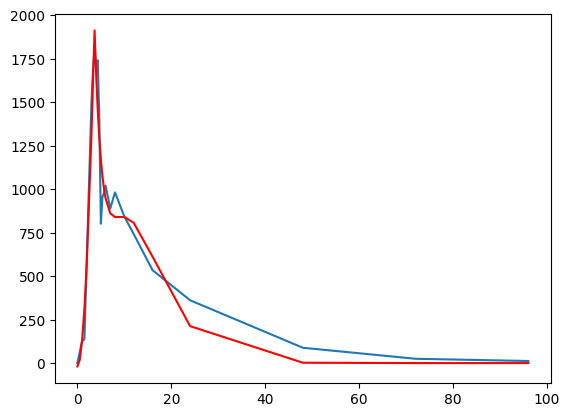

[ -0.12840706   3.50243131 -11.92510323 106.06869712]
(-0.10686422839518278, 480.9961734645823, -33.07645437620301, 1618.1515707306928)


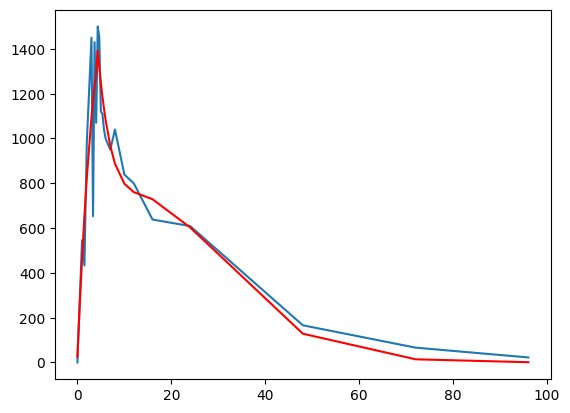

[ -0.12199526   4.06012306 -11.40476367  87.43676282]
(-0.11727030295112462, 147.275771532203, -33.07645437620301, 1797.837679857654)


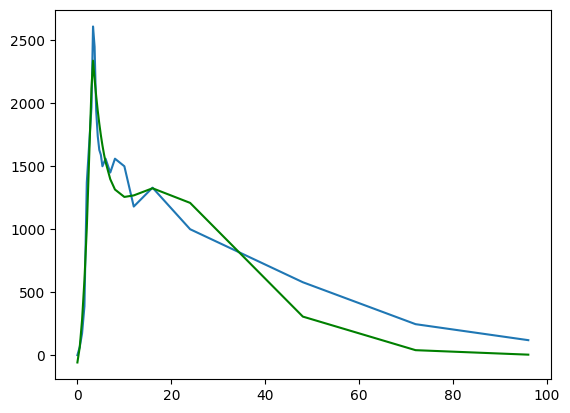

[-9.54059593e-02  2.00025084e+00 -7.76823176e+00  2.84085465e+02]
(-0.15815915554722354, -285.8499804895059, -33.07645437620301, nan)


/tmp/ipykernel_3155/3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


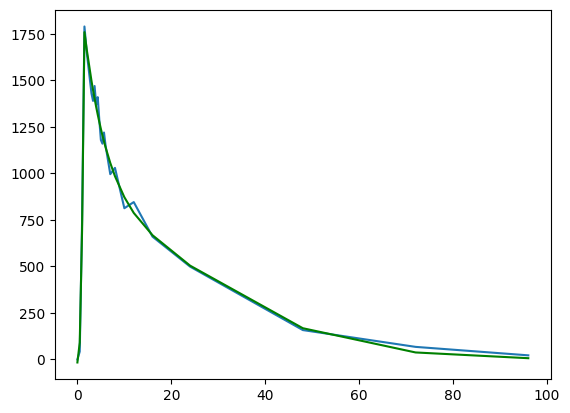

[ -0.17579807   4.87943913 -11.07812418  61.44681928]
(-0.1324889705314601, 1061.195181751491, -33.07645437620301, 528.501051372218)


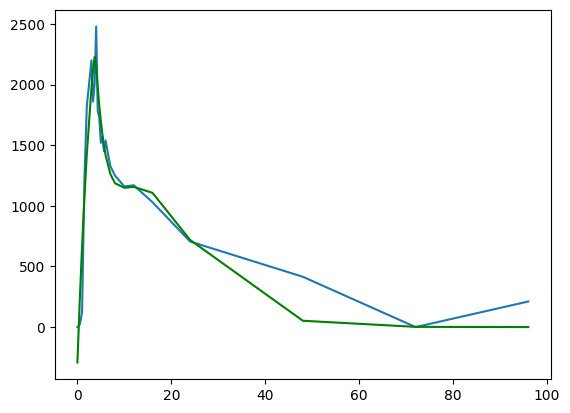

[ -0.2252405    5.61303535 -10.68324354  42.83847768]
(-0.1332826903784346, 1069.7569245041273, -33.07645437620301, 503.5034253735448)


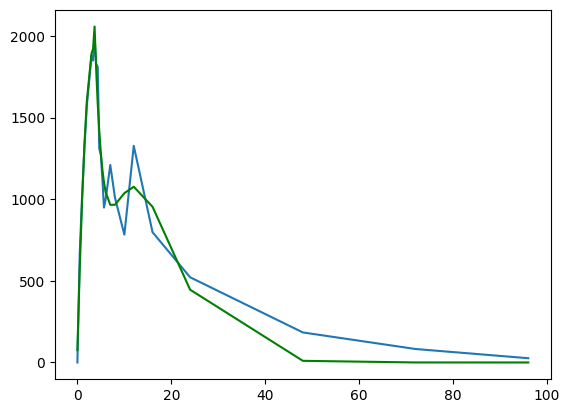

[ -0.17980791   4.44176143 -12.0127481   64.278702  ]
(-0.10950347373160914, 322.9471873105615, -33.07645437620301, 1735.7548811817264)


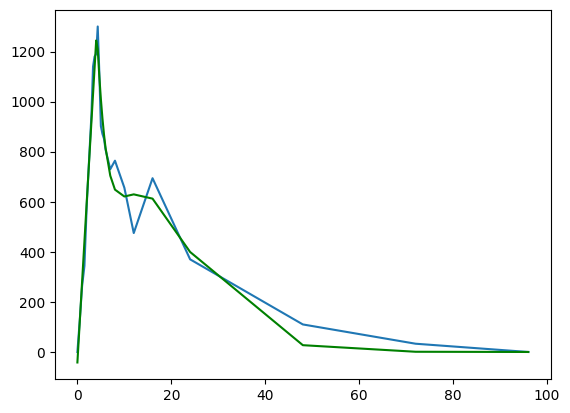

[-7.63166576e-02  1.51987891e+00 -7.97763401e+00  3.06461113e+02]
(-0.1248033101878799, 36.249462370760845, -33.07645437620301, 1808.5158435881106)


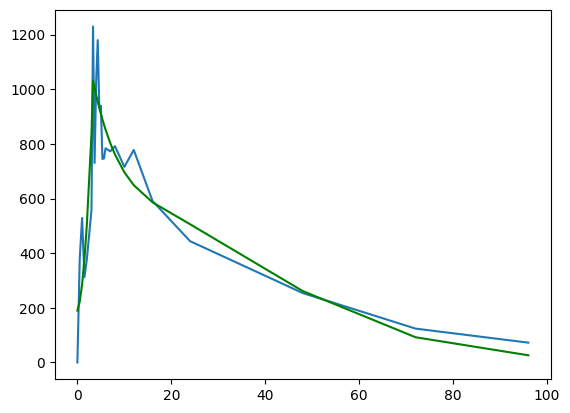

[ -0.14262589   3.88360319 -12.19261505  83.81352125]
(-0.11071136393668628, 720.4055854627106, -33.07645437620301, 1304.7220159190047)


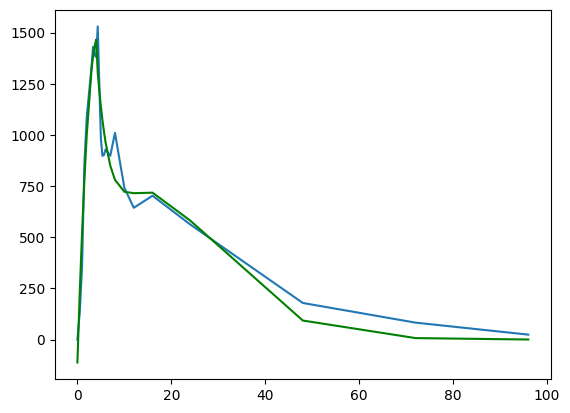

[-5.16826060e-02  1.21099876e+00 -8.49624003e+00  5.01944751e+02]
(-0.1152304893082986, 822.5772928152405, -33.07645437620301, 1115.1898075764507)


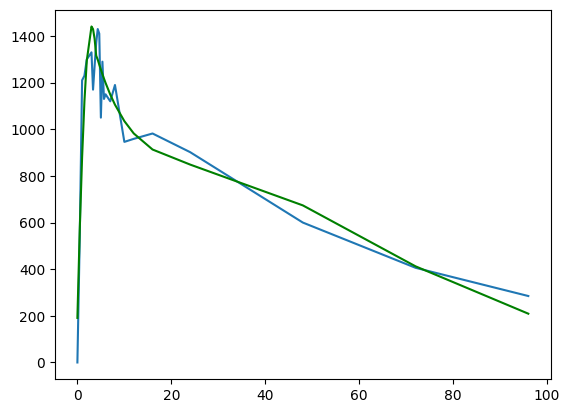

[-5.68768852e-02  1.13138407e+00 -1.73556003e+01  5.41514287e+02]
(-0.11776480730459352, 867.5428457647149, -33.07645437620301, 1020.4125774448382)


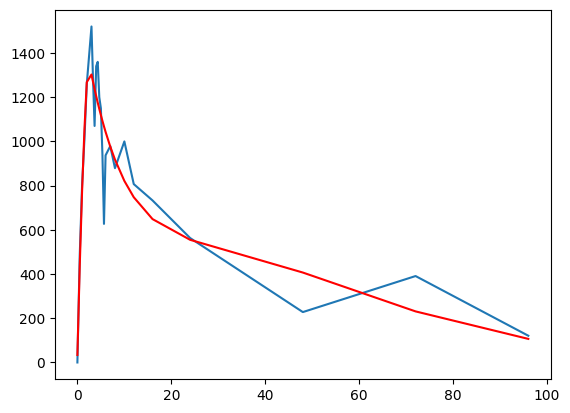

[-8.36791445e-02  1.99359615e+00 -5.74821421e+00  2.51116050e+02]
(-0.15721910811625128, 1285.0828309400088, -33.07645437620301, -220.58061224397397)


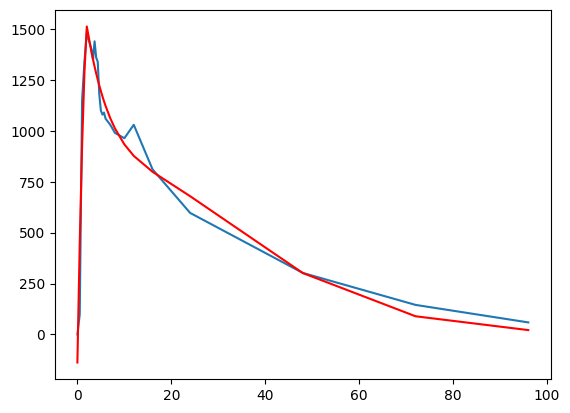

[-0.12874422  3.09823251 -5.78755406 83.92632559]
(-0.1430683593565352, -159.80003225947326, -33.07645437620301, nan)


/tmp/ipykernel_3155/3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


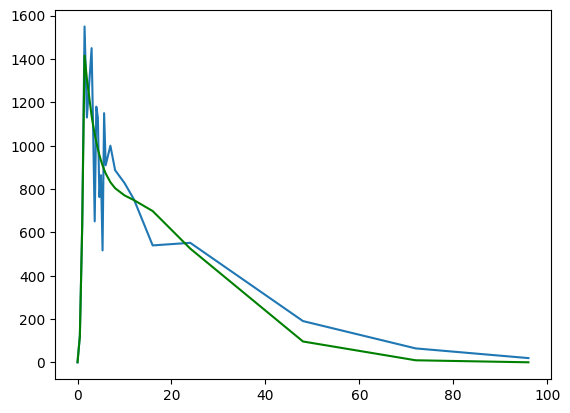

[ 2.60663318e-02 -1.59548731e+00 -1.57468535e+02  6.20610250e+03]
(-0.10736967031023001, 584.644207781499, -33.07645437620301, 1503.8430968702792)


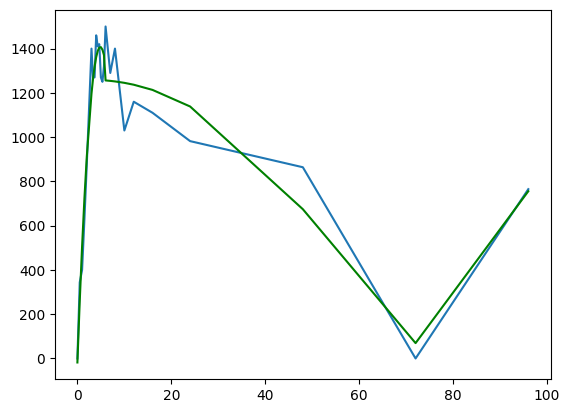

[-1.08959705e-01  3.24466364e+00 -1.14052155e+01  1.38974932e+02]
(-0.13100787592192892, 1044.8570361662728, -33.07645437620301, 575.4216156604784)


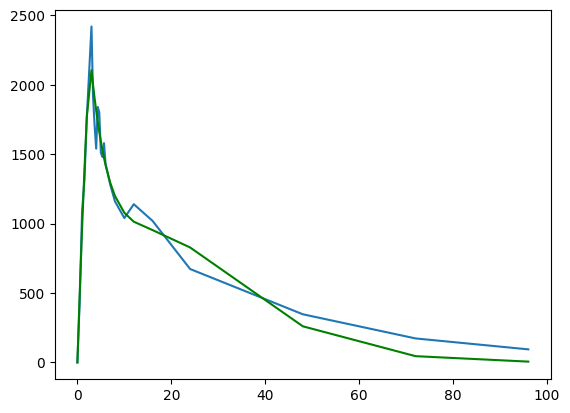

[-9.35906521e-02  1.62458628e+00 -2.15816411e+01  4.72807832e+02]
(-0.10881042069105126, 347.9999977093888, -33.07645437620301, 1721.3501097765043)


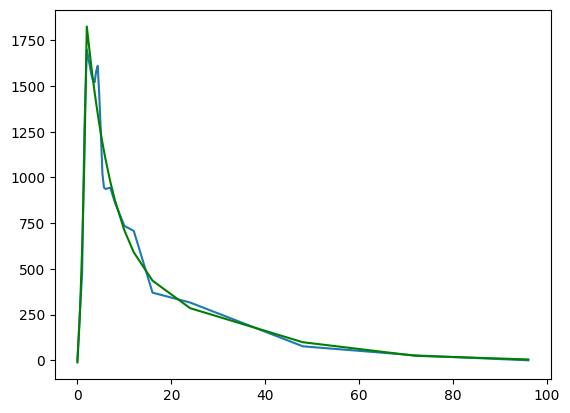

[-6.82151368e-02  2.16644778e+00 -1.14779259e+01  3.42121336e+02]
(-0.120629488247391, 912.4635627151935, -33.07645437620301, 918.5739373493948)


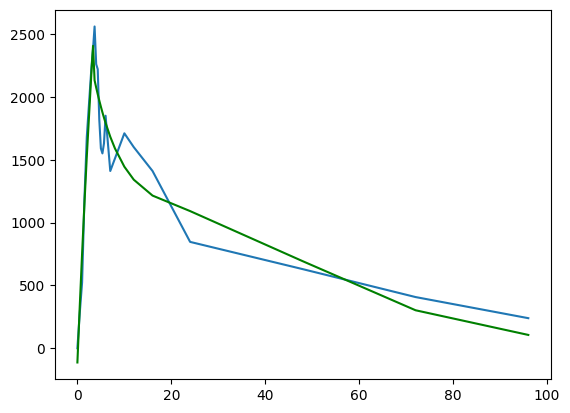

[-2.46811356e-03 -1.81496826e+00 -2.00447999e+02  1.06450434e+04]
(-0.11073828510655578, 721.1561248903968, -33.07645437620301, 1303.4572126636315)


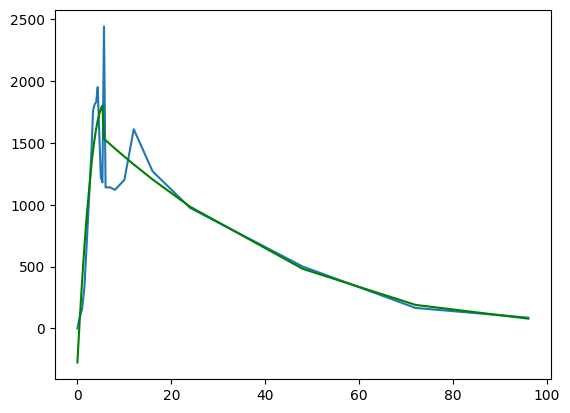

[-8.06311463e-02  1.31461967e+00 -3.37624715e+00  3.39553954e+02]
(-0.10875004420203488, 656.1142806667577, -33.07645437620301, 1406.2759628980982)


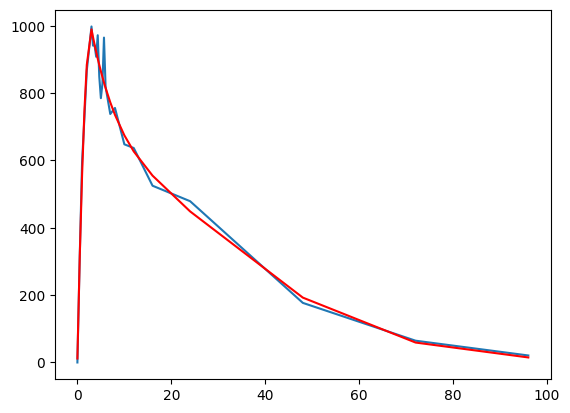

[-1.07010315e-01  3.06491008e+00 -1.52488683e+01  1.39169599e+02]
(-0.1078200438302173, 613.1932744253511, -33.07645437620301, 1466.7615464265714)


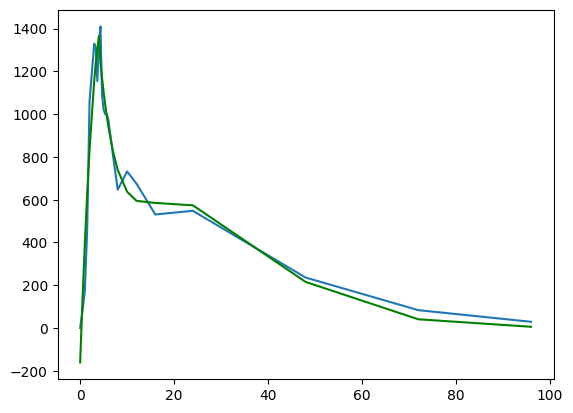

[-9.41403132e-02  3.18957051e+00 -1.20866478e+01  1.39539183e+02]
(-0.11998594833777386, 902.8123512710573, -33.07645437620301, 941.0647317357266)


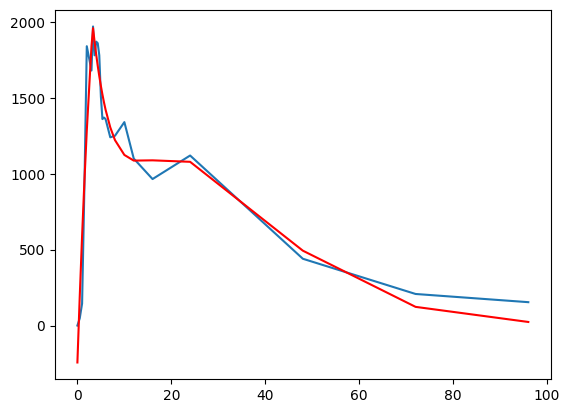

[-8.40980519e-02  1.64904661e+00 -1.15722577e+01  3.52496384e+02]
(-0.11126653220508917, 735.3927860109522, -33.07645437620301, 1279.1139996646707)


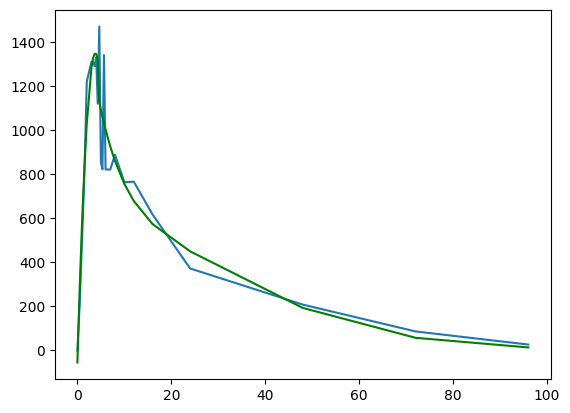

[ -0.24599538   5.91301529 -10.10265294  37.10233734]
(-0.1591304471420214, 1299.7710865343422, -33.07645437620301, -276.84497545558634)


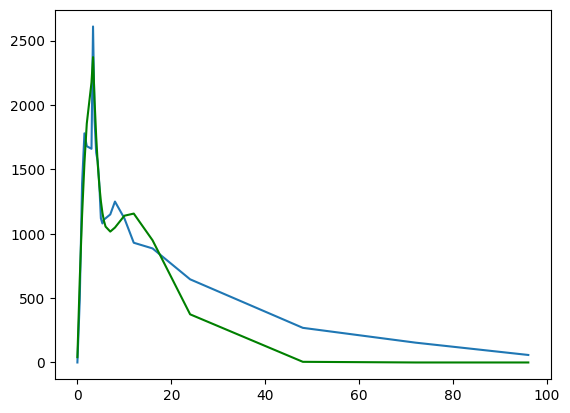

[-0.22694455  4.99421546 -9.9805285  47.39358554]
(-0.10782786272609417, 392.86737231859, -33.07645437620301, 1691.6871949110932)


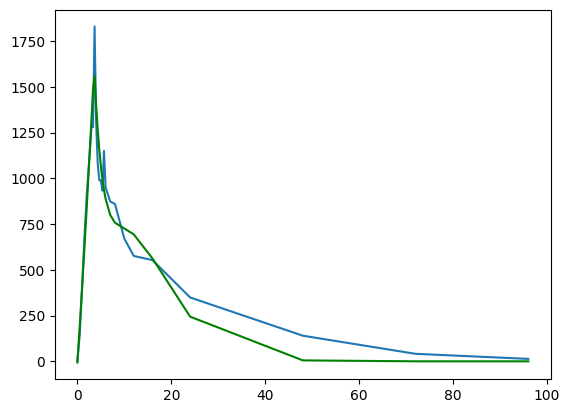

[ -0.17756343   4.43447295 -10.87098185  52.146244  ]
(-0.1276965916893613, 0.07647675805222565, -33.07645437620301, 1808.8948864323759)


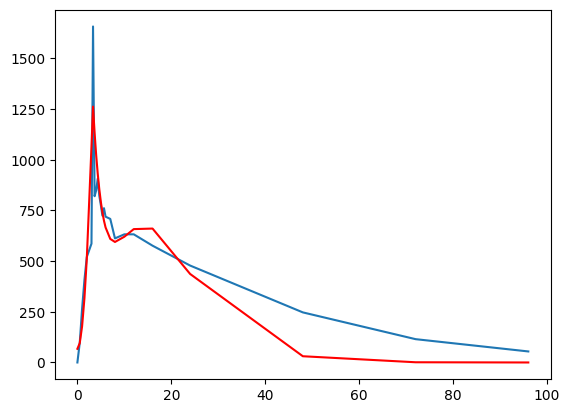

[-6.25617380e-02  1.79273195e+00 -1.03694897e+01  3.05076397e+02]
(-0.11437014956119795, 200.6941316048167, -33.07645437620301, 1785.6115727341412)


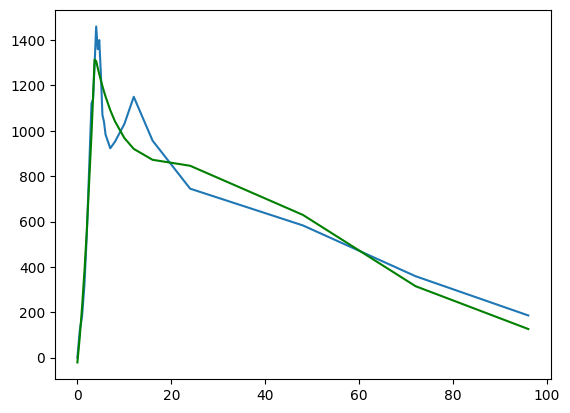

[-6.15101348e-02  1.74457288e+00 -8.66167610e+00  3.16838474e+02]
(-0.11770768785496424, 866.5906958676356, -33.07645437620301, 1022.4932328042593)


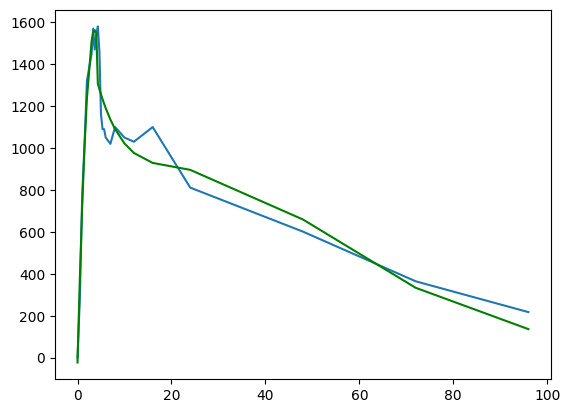

[ -0.21878744   5.47518062 -10.94498762  47.45940223]
(-0.11198293455987307, 753.4092367422792, -33.07645437620301, 1247.34404803288)


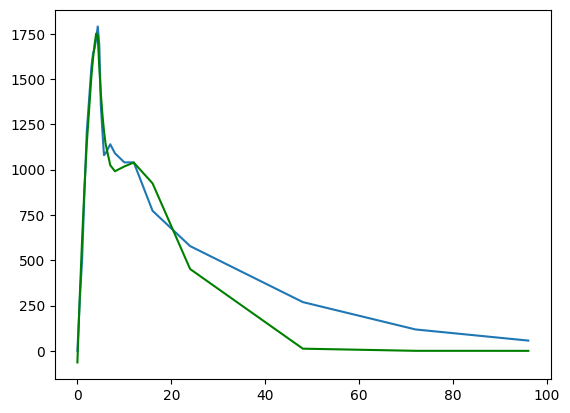

[-0.17139839  4.00781591 -7.98491461 57.50916806]
(-0.10781880038324554, 613.1246646689058, -33.07645437620301, 1466.8536504787203)


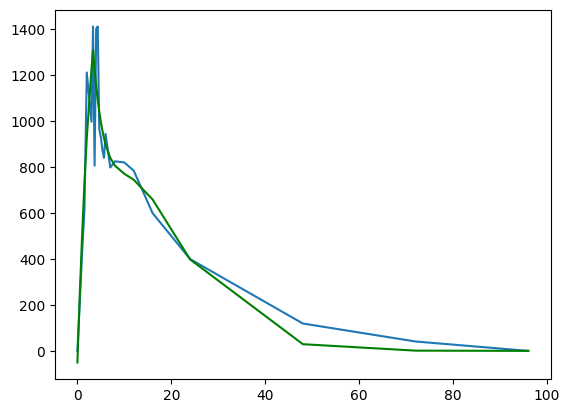

[-1.06542379e-01  2.95966004e+00 -9.37975936e+00  1.46413786e+02]
(-0.11961164182209175, 897.090081596779, -33.07645437620301, 954.2411246203792)


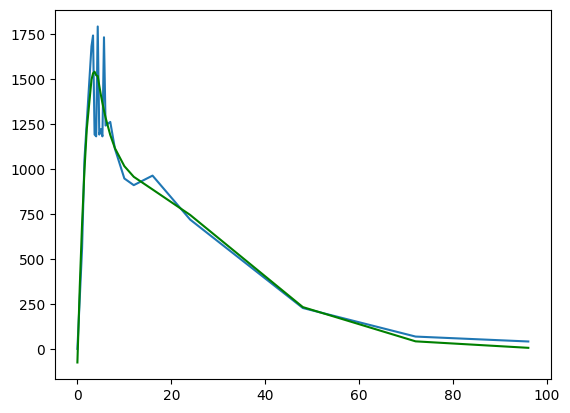

[-9.19914864e-02  2.84032703e+00 -9.06688665e+00  1.54837931e+02]
(-0.12207578062984747, 933.3641863933984, -33.07645437620301, 868.7108563082447)


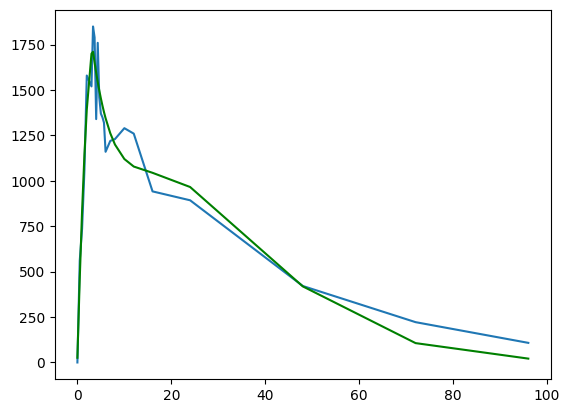

[-0.1356794   3.86073329 -9.41709257 86.79984335]
(-0.10876599985100162, 656.7459775836669, -33.07645437620301, 1405.3426089127197)


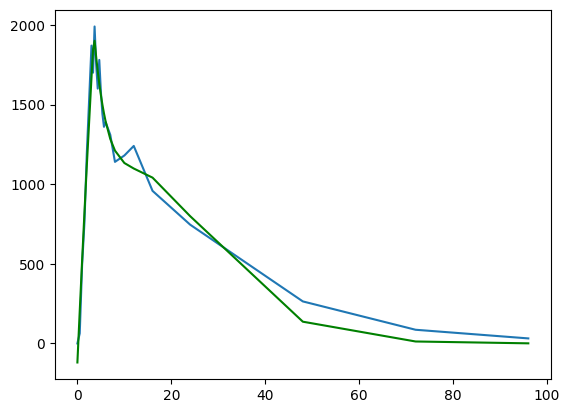

[-0.28059514  5.91048215 -9.70739871 37.29244108]
(-0.10705808308712308, 556.5969834371817, -33.07645437620301, 1537.8759757684963)


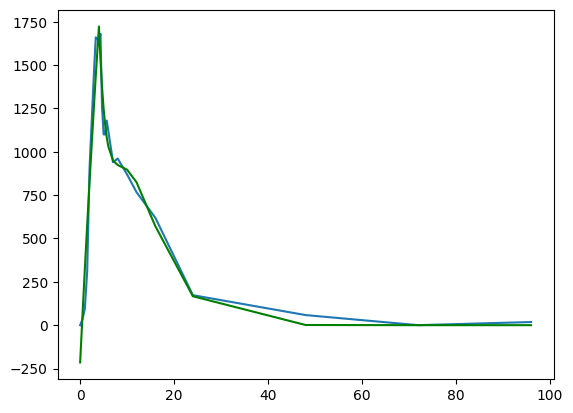

[ -0.18006425   4.35511897 -11.20991245  64.26929561]
(-0.11125480803450213, 735.0862971276651, -33.07645437620301, 1279.6451205598123)


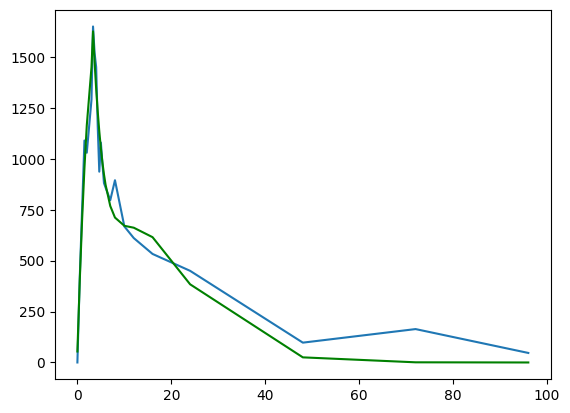

[-0.17972517  4.06432138 -6.16613515 50.78696814]
(-0.12221032779250755, 935.2571445036394, -33.07645437620301, 864.1162240182906)


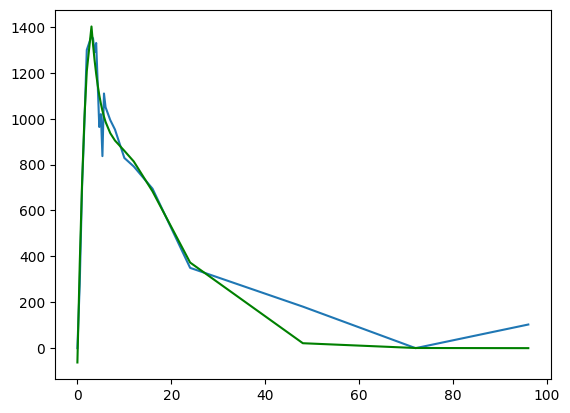

[ 6.27145661e-03 -2.22427763e+00 -1.96564431e+02  1.11930665e+04]
(-0.1082471321697811, 634.6564608560391, -33.07645437620301, 1437.2338929120472)


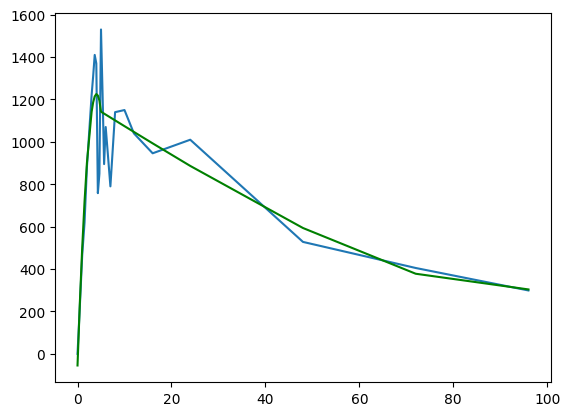

[ -0.14926331   4.26857214 -11.04455577  66.98838471]
(-0.10819174731083506, 632.0750589341221, -33.07645437620301, 1440.8609120604801)


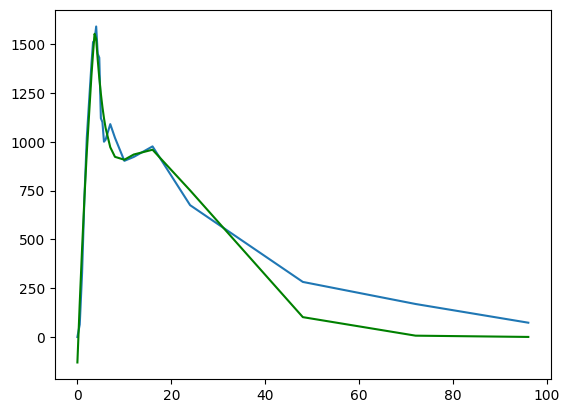

[-9.45383110e-02  1.71948440e+00 -4.96900114e+00  2.85972849e+02]
(-0.1187070465792242, 123.5860680182887, -33.07645437620301, 1801.6440841679535)


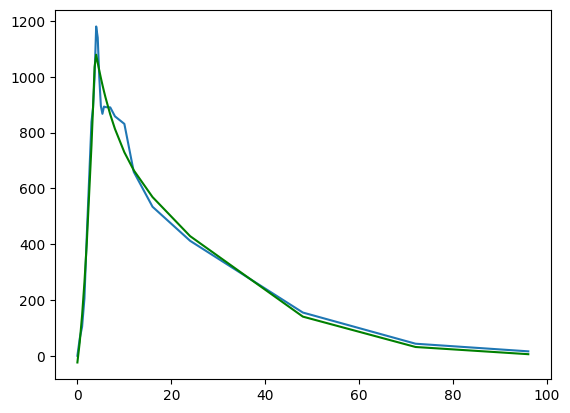

[-6.71604623e-02  1.04437859e+00 -9.46133644e+00  5.60274878e+02]
(-0.10895004603540588, 342.6380991541735, -33.07645437620301, 1724.5606501366674)


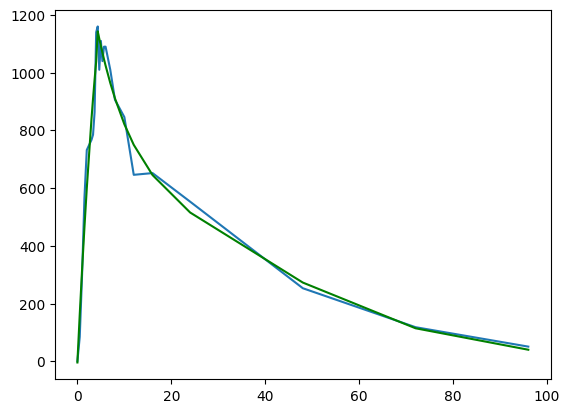

[-0.23213538  5.11401804 -9.1439402  46.2746664 ]
(-0.10781956387151653, 613.1667967868428, -33.07645437620301, 1466.7970926191572)


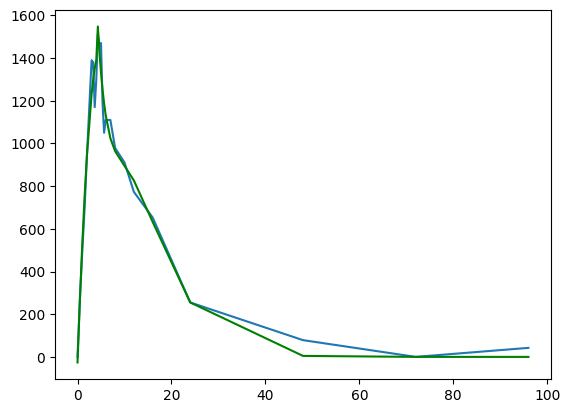

[ 1.47352442e-02 -2.42570255e+00 -2.04466839e+02  1.25480879e+04]
(-0.11838538612197075, 128.75953730424786, -33.07645437620301, 1800.8921233890946)


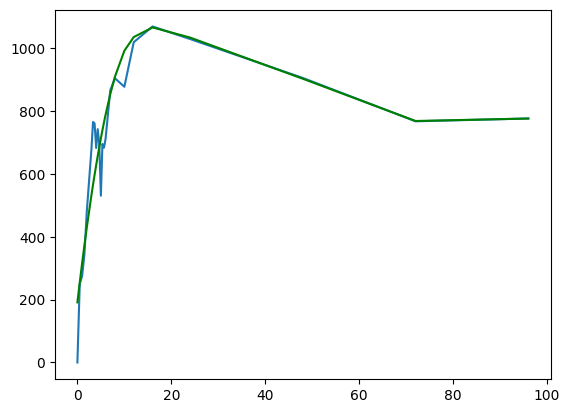

[-8.00862490e-02  2.76542680e+00 -1.65391075e+01  2.43491157e+02]
(-0.10708846164389922, 559.945189414941, -33.07645437620301, 1533.9365368822491)


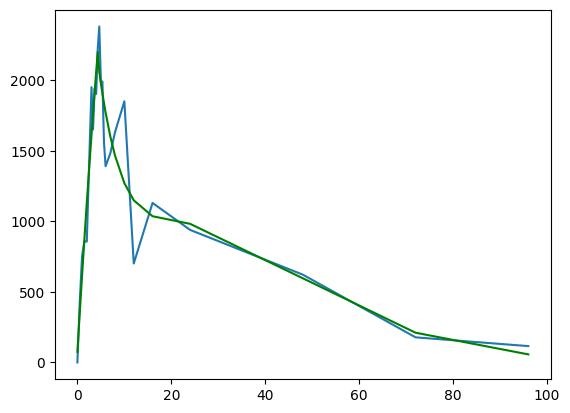

[ -0.15238684   4.08720618 -11.44155594  60.26768484]
(-0.10923702745069408, 332.144217839704, -33.07645437620301, 1730.6422695073409)


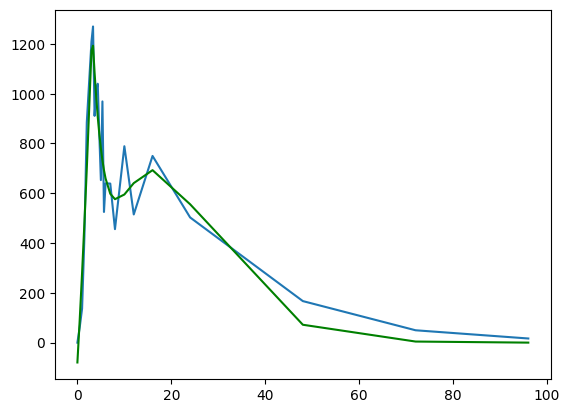

[-5.19412272e-02  1.65203140e+00 -1.99707166e+01  4.09747561e+02]
(-0.13346007675351212, -65.16164160518542, -33.07645437620301, nan)


/tmp/ipykernel_3155/3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


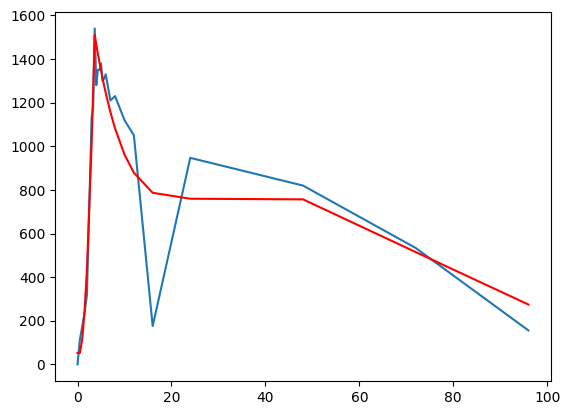

[-8.11336983e-02  2.95250645e+00 -1.51301370e+01  1.66090894e+02]
(-0.10758830650781553, 406.92489440648916, -33.07645437620301, 1681.3407754621787)


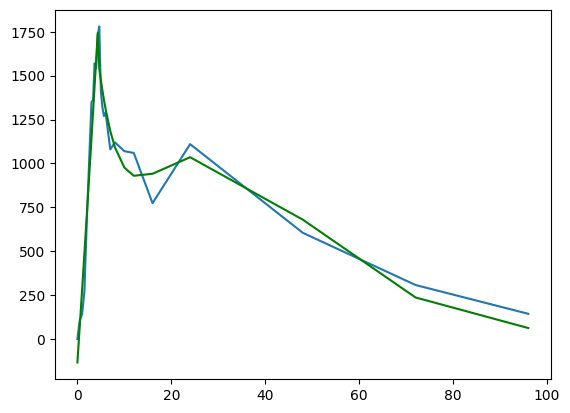

[-7.86650586e-02  1.25007129e+00 -1.27521103e+01  4.77848712e+02]
(-0.11848018814164127, 127.22737838827466, -33.07645437620301, 1801.119345476231)


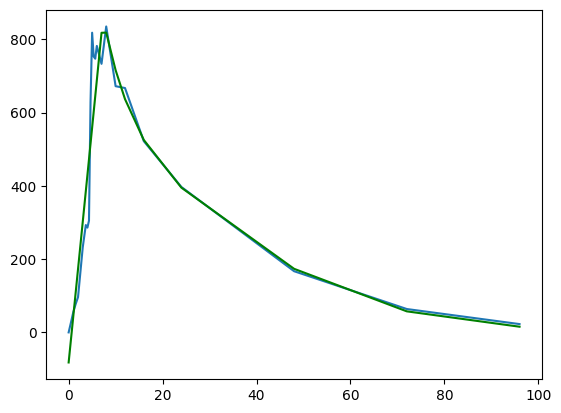

[ 6.96219118e-03 -1.83619430e+00 -1.66656373e+02  6.89227515e+03]
(-0.10971154358702173, 316.0791474375837, -33.07645437620301, 1739.4417825274609)


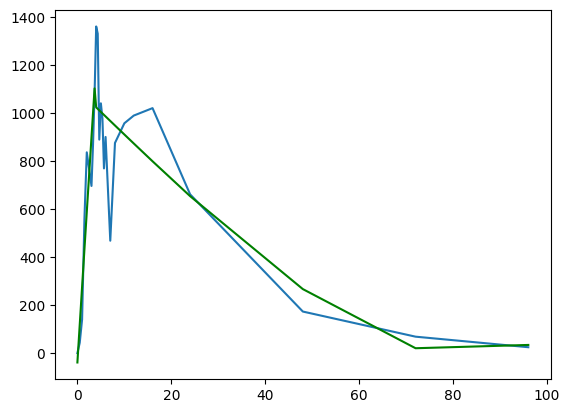

[ 7.26619526e-03 -1.96513029e+00 -1.87007036e+02  9.43622543e+03]
(-0.13393676853307893, -70.2252173664446, -33.07645437620301, nan)


/tmp/ipykernel_3155/3254944840.py:2: RuntimeWarning: invalid value encountered in scalar power
  return a / x ** b + c


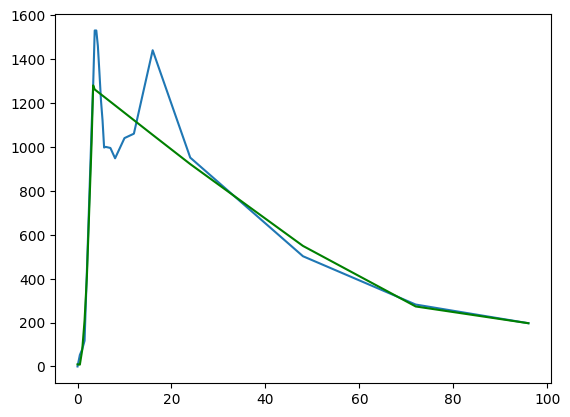

[ 1.10329813e-02 -2.15326337e+00 -1.98961719e+02  9.98709751e+03]
(-0.10704556588495241, 555.1545983531149, -33.07645437620301, 1539.5628287974077)


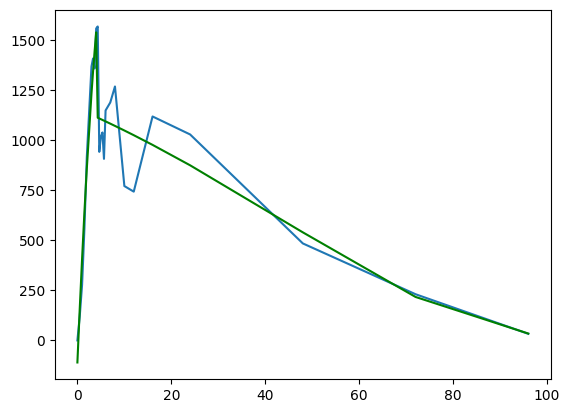

In [49]:
for i in range(len(df)):
    x = np.array([float(elem) for elem in df.drop(['area', 'max'], axis=1).columns])
    y = np.array(df.iloc[i,][:-2])
    try:
        new_check_fit(x, y, f1, f2)
    except RuntimeError:
        pass

In [50]:
pvalues = np.array(pvalues)
success = pvalues > alpha
np.mean(success)

0.8571428571428571